# DSPT7 Unit 2 Build Week Project:

## Predicting the frequency of the shape of reported UFO's in North America

* Source for my original dataset: [UFO Sightings from Kaggle]('https://www.kaggle.com/NUFORC/ufo-sightings?select=scrubbed.csv')  
* Based on data from: [National UFO Reporting Center (NUFORC)]('http://www.nuforc.org/')
  

## Start Code:

In [1]:
%%capture
import sys

# If you're on Colab:
# if 'google.colab' in sys.modules:
#     DATA_PATH = 'https://www.kaggle.com/NUFORC/ufo-sightings?select=scrubbed.csv'
#     !pip install category_encoders==2.*
#     !pip install pandas-profiling==2.*
    
# If you're working locally (I am working locally):
# else:
DATA_PATH = '../data/'
#     !pip install category_encoders==2.*
#     !pip install pandas-profiling==2.*
#     !pip install plotly==4.9.0

## Imports:

In [2]:
# Imports:
import pandas as pd
import pandas_profiling
from pandas_profiling import ProfileReport
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import IPython
from IPython.display import HTML
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly as py
from plotly.graph_objs import *
import plotly.express as px
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')
import category_encoders as ce
from sklearn import metrics
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.compose import ColumnTransformer
from pdpbox import pdp
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot

## Read in my data:

In [3]:
# Read in my data:
data = 'https://raw.githubusercontent.com/jmmiddour/Projects/master/UFOs/ufo_sightings_scrubbed.csv'
ufos = pd.read_csv(data)

# Look at the first 5 rows:
ufos.head()

datetime                  city state country     shape  \
0  10/10/1949 20:30            san marcos    tx      us  cylinder   
1  10/10/1949 21:00          lackland afb    tx     NaN     light   
2  10/10/1955 17:00  chester (uk/england)   NaN      gb    circle   
3  10/10/1956 21:00                  edna    tx      us    circle   
4  10/10/1960 20:00               kaneohe    hi      us     light   

  duration (seconds) duration (hours/min)  \
0               2700           45 minutes   
1               7200              1-2 hrs   
2                 20           20 seconds   
3                 20             1/2 hour   
4                900           15 minutes   

                                            comments date posted    latitude  \
0  This event took place in early fall around 194...   4/27/2004  29.8830556   
1  1949 Lackland AFB&#44 TX.  Lights racing acros...  12/16/2005    29.38421   
2  Green/Orange circular disc over Chester&#44 En...   1/21/2008        53.2   
3  My older brother and twin sister were leaving ...   1/17/2004  28.9783333   
4  AS a Marine 1st Lt. flying an FJ4B fighter/att...   1/22/2004  21.4180556   

    longitude  
0  -97.941111  
1  -98.581082  
2   -2.916667  
3  -96.645833  
4 -157.803611

## Pandas Profile:

In [4]:
# Look at the profile for this dataset:
profile = ProfileReport(ufos, title='UFO Sightings (Original Data Set) 1906-2014', 
                        html={'style': {'full_width':True}}, plot={'histogram': {'bins': 50}}, explorative=True)
# profile.to_notebook_iframe()
profile

In [5]:
# Turn profile report into a html file to add to blog post:
profile.to_file('UFO_pd_profile_report.html')

## Target Feature:

In [6]:
# Reduce the dimensionality of my target feature by group like variables into new classes:
ufos['shape_class'] = ufos['shape']
ufos['shape_class'] = ufos['shape_class'].replace(['other', 'unknown', np.nan], 'Other')
ufos['shape_class'] = ufos['shape_class'].replace(['circle', 'sphere', 'disk', 'round', 'oval'], 'Circular')
ufos['shape_class'] = ufos['shape_class'].replace(['triangle', 'hexagon', 'delta', 'chevron', 'rectangle', 
                                                   'diamond'], 'Geometric')
ufos['shape_class'] = ufos['shape_class'].replace(['pyramid', 'cylinder', 'egg', 'cone', 'dome', 
                                                   'cigar', 'cross', 'crescent', 'teardrop'], 'Non-Geometric')
ufos['shape_class'] = ufos['shape_class'].replace(['formation', 'changed', 'changing'], 'Multiple')
ufos['shape_class'] = ufos['shape_class'].replace(['light', 'fireball', 'flash', 'flare'], 'Type of Light')

# Check my work:
ufos['shape_class'].value_counts(normalize=True)

Type of Light    0.300030
Circular         0.273154
Other            0.163882
Geometric        0.140666
Non-Geometric    0.067246
Multiple         0.055022
Name: shape_class, dtype: float64

## Clean and explore my data:

### Dates and Times:

In [7]:
# Look at the length of a value that is the length it should be for formatting:
len(ufos['datetime'][0])

16

In [8]:
# Create a new column with length values of datetime values:
ufos['dt_len'] = ufos['datetime'].str.len()
ufos.head(3)

datetime                  city state country     shape  \
0  10/10/1949 20:30            san marcos    tx      us  cylinder   
1  10/10/1949 21:00          lackland afb    tx     NaN     light   
2  10/10/1955 17:00  chester (uk/england)   NaN      gb    circle   

  duration (seconds) duration (hours/min)  \
0               2700           45 minutes   
1               7200              1-2 hrs   
2                 20           20 seconds   

                                            comments date posted    latitude  \
0  This event took place in early fall around 194...   4/27/2004  29.8830556   
1  1949 Lackland AFB&#44 TX.  Lights racing acros...  12/16/2005    29.38421   
2  Green/Orange circular disc over Chester&#44 En...   1/21/2008        53.2   

   longitude    shape_class  dt_len  
0 -97.941111  Non-Geometric      16  
1 -98.581082  Type of Light      16  
2  -2.916667       Circular      16

In [9]:
# Look at the value counts of the new column and shape of dataframe 
#   before dropping rows with strange time formatting:
print('Datetime Length Frequencies before removing rows:\n\n', ufos['dt_len'].value_counts(), '\n')
print('Number of Observations before removing rows =', ufos.shape[0], '\n')

# Drop all rows with strange time (length more than 16):
ufos = ufos.drop(ufos.loc[ufos['dt_len'] >= 17].index)

# Check my work by looking at the new value counts and shape:
print('Datetime Length Frequencies after removing rows:\n\n', ufos['dt_len'].value_counts(), '\n')
print('Number of Observations after removing rows =', ufos.shape[0])

Datetime Length Frequencies before removing rows:

 15    38698
14    25611
16    10831
13     4498
22      380
21      193
23      120
20        1
Name: dt_len, dtype: int64 

Number of Observations before removing rows = 80332 

Datetime Length Frequencies after removing rows:

 15    38698
14    25611
16    10831
13     4498
Name: dt_len, dtype: int64 

Number of Observations after removing rows = 79638


In [10]:
# Need to change datetime feature to datetime data type:
ufos['datetime'] = pd.to_datetime(ufos['datetime'], infer_datetime_format=True)

# Check my work by looking at the data type now:
ufos['datetime'].dtypes

dtype('<M8[ns]')

In [11]:
# Break down the date of the sighting:
ufos['year'] = ufos['datetime'].dt.year
ufos['month'] = ufos['datetime'].dt.month
ufos['hour'] = ufos['datetime'].dt.hour
ufos['day'] = ufos['datetime'].dt.day
ufos['dow'] = ufos['datetime'].dt.weekday

# Change the dow to the name of the day for easier readability for right now:
ufos['dow'] = ufos['dow'].replace(range(0, 7), ['Mon', 'Tue', 'Wed', 'Thr', 'Fri', 'Sat', 'Sun'])

# Drop the datetime + dt_len, no longer need, and date posted + durations (hours/min), is not usable for me:
ufos.drop(columns=['datetime', 'dt_len', 'date posted', 'duration (hours/min)'], inplace=True)

# Check my work:
ufos.head()

city state country     shape duration (seconds)  \
0            san marcos    tx      us  cylinder               2700   
1          lackland afb    tx     NaN     light               7200   
2  chester (uk/england)   NaN      gb    circle                 20   
3                  edna    tx      us    circle                 20   
4               kaneohe    hi      us     light                900   

                                            comments    latitude   longitude  \
0  This event took place in early fall around 194...  29.8830556  -97.941111   
1  1949 Lackland AFB&#44 TX.  Lights racing acros...    29.38421  -98.581082   
2  Green/Orange circular disc over Chester&#44 En...        53.2   -2.916667   
3  My older brother and twin sister were leaving ...  28.9783333  -96.645833   
4  AS a Marine 1st Lt. flying an FJ4B fighter/att...  21.4180556 -157.803611   

     shape_class  year  month  hour  day  dow  
0  Non-Geometric  1949     10    20   10  Mon  
1  Type of Light  1949     10    21   10  Mon  
2       Circular  1955     10    17   10  Mon  
3       Circular  1956     10    21   10  Wed  
4  Type of Light  1960     10    20   10  Mon

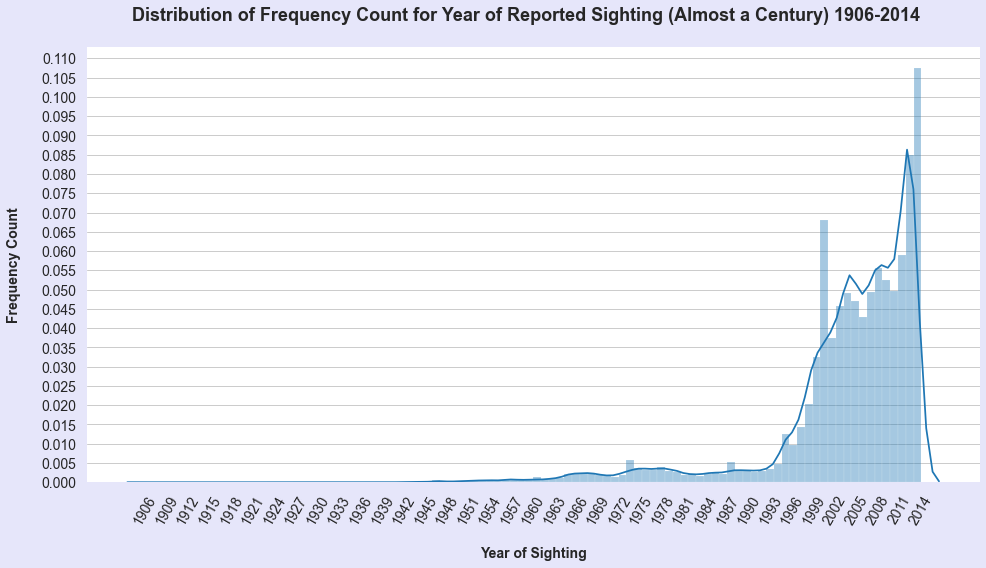

In [12]:
# Look at a distribution plot of year:
plt.figure(figsize=(16, 8), facecolor='lavender')
sns.distplot(ufos.year, bins=100)
plt.title(f'Distribution of Frequency Count for Year of Reported Sighting (Almost a Century) 1906-2014   \n', size=18, weight='bold')
plt.xlabel(f'\nYear of Sighting', size=14, weight='bold')
plt.ylabel(f'Frequency Count\n', size=14, weight='bold')
plt.xticks(np.arange(1906, 2016, step=3), rotation=60, size=14, )
plt.yticks(np.arange(-0.00, 0.115, step=0.005), size=14)
plt.grid(axis='y');

In [13]:
# Drop all rows prior to 1994 due to lack of data:
ufos.drop(ufos[ufos['year'] <= 1993].index, inplace=True)

# Reset the index and rename old index numbers:
ufos = ufos.reset_index().rename(columns={'index':'Id'})

# Check my work:
ufos['year'].value_counts(normalize=True).sort_index(ascending=False)

2014    0.031087
2013    0.096520
2012    0.100882
2011    0.070085
2010    0.058779
2009    0.062230
2008    0.065943
2007    0.058572
2006    0.050828
2005    0.055756
2004    0.058254
2003    0.054320
2002    0.044326
2001    0.042918
2000    0.037990
1999    0.038486
1998    0.024006
1997    0.017145
1996    0.011402
1995    0.014715
1994    0.005756
Name: year, dtype: float64

In [14]:
# Look at the first 2 rows to make sure the column rename worked:
ufos.head(2)

Id         city state country      shape duration (seconds)  \
0  58    mercedies    tx     NaN      cigar               3600   
1  59  burnt hills    ny      us  rectangle                120   

                                            comments    latitude  longitude  \
0  ufo chased by fighter jet over Rio Grande Vall...   26.149798 -97.913611   
1  Giant rectangular craft (resembling an upside-...  42.9097222 -73.895556   

     shape_class  year  month  hour  day  dow  
0  Non-Geometric  1994     10    15   10  Mon  
1      Geometric  1994     10    18   10  Mon

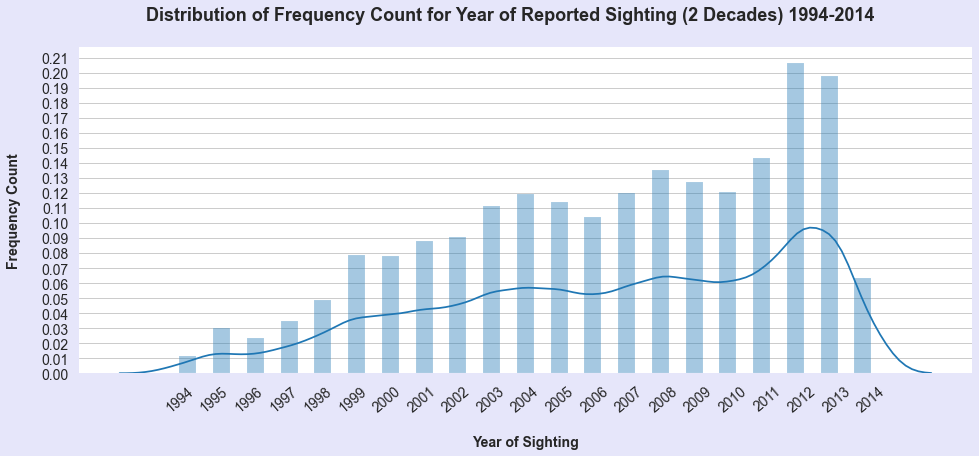

In [15]:
# Look at a distribution plot of year:
plt.figure(figsize=(16, 6), facecolor='lavender')
sns.distplot(ufos.year, bins=41)
plt.title(f'Distribution of Frequency Count for Year of Reported Sighting (2 Decades) 1994-2014      \n', 
          size=18, weight='bold')
plt.xlabel(f'\nYear of Sighting', size=14, weight='bold')
plt.ylabel(f'Frequency Count\n', size=14, weight='bold')
plt.xticks(np.arange(1994, 2015, step=1), rotation=40, size=14, )
plt.yticks(np.arange(0, 0.22, step=0.01), size=14)
plt.grid(axis='y');

In [16]:
# Look at the shape of my new dataset with reduction in years:
ufos.shape

(72441, 15)

In [17]:
# Find out why durations in secs is not supported in the profile:
print(ufos['duration (seconds)'].dtypes)

# Look at the value counts:
ufos['duration (seconds)'].value_counts()

object


300     6218
120     5175
600     4531
60      4343
180     3755
        ... 
0.38       1
125        1
570        1
4260       1
615        1
Name: duration (seconds), Length: 667, dtype: int64

In [18]:
# Change column names - replace spaces with underscores and removing () also: 
ufos = ufos.rename(columns={'duration (seconds)': 'durations_in_secs'})

In [19]:
# Need to replace values first that have typos:
ufos['durations_in_secs'].replace(['2`', '8`', '0.5`'], [2, 8, 0.5], inplace=True)

# Format the values to floats and all have 1 decimal place:
ufos['durations_in_secs'] = ufos['durations_in_secs'].astype(float).round(decimals=1)

# Check my work
print(ufos['durations_in_secs'].dtypes)
ufos.head(3)

float64


Id         city state country      shape  durations_in_secs  \
0  58    mercedies    tx     NaN      cigar             3600.0   
1  59  burnt hills    ny      us  rectangle              120.0   
2  60   pinebergen    ar      us      light                5.0   

                                            comments    latitude  longitude  \
0  ufo chased by fighter jet over Rio Grande Vall...   26.149798 -97.913611   
1  Giant rectangular craft (resembling an upside-...  42.9097222 -73.895556   
2  Round&#44 bright&#44 low flying object silentl...  34.1027778 -91.992222   

     shape_class  year  month  hour  day  dow  
0  Non-Geometric  1994     10    15   10  Mon  
1      Geometric  1994     10    18   10  Mon  
2  Type of Light  1994     10    22   10  Mon

### Handle NaN Values:

In [20]:
# Look for null values:
ufos.isnull().sum()

Id                      0
city                    0
state                5133
country              8413
shape                1765
durations_in_secs       0
comments               12
latitude                0
longitude               0
shape_class             0
year                    0
month                   0
hour                    0
day                     0
dow                     0
dtype: int64

In [21]:
# Replace all null values with 0 for right now, then will change it back to impute the values later:
ufos = ufos.replace(np.nan, 0)

# Check my work:
ufos.isnull().sum()

Id                   0
city                 0
state                0
country              0
shape                0
durations_in_secs    0
comments             0
latitude             0
longitude            0
shape_class          0
year                 0
month                0
hour                 0
day                  0
dow                  0
dtype: int64

## Apply re (Real Expression) to Comments and City Features:

In [22]:
# Look at the number of rows in comments and city:
print('Comments', ufos.comments.shape[0])
print('City', ufos.city.shape[0])

Comments 72441
City 72441


In [23]:
# Import new libraries:
import re
import string

# Create a function to do first clean on the comments column:
def clean_text1(text):
  '''
  Remove text in [ ], punctuation, and numbers, and make text lowercase 
  '''
  text = re.sub('[^a-zA-Z]',  ' ', str(text)) # Converts all values to strings with spaces
  text = re.sub('[&#*\d]', '', text)  # Removes text in [ ]
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # Removes punctuation
  text = text.lower()  # Makes all text lowercase
  return text

In [24]:
# Test out my function on some of the comment values:
print (clean_text1('OBJECT SPEED APPX. 70 MPH'))
print (clean_text1('Five sightings of glowing red orange fireball object over Pittsburg&#44 CA'))
print (clean_text1('Round&#44 bright&#44 low flying object silentl'))

object speed appx     mph
five sightings of glowing red orange fireball object over pittsburg     ca
round     bright     low flying object silentl


In [25]:
# Loop through all values in column:
re1 = lambda x: clean_text1(x)

# Apply to comments column:
ufo_c1 = pd.DataFrame(ufos.comments.apply(re1))
ufo_c1.sample(20)

comments
49867  unknown lights and unexplained observation on ...
16418  a silver metallic object streaked across the s...
43452    hoax      we saw the object on the horizon o...
9572                           orange lights and crafts 
6945   large light shot over sky   grew smaller and t...
64303  strange slow moving red lights in the northern...
2836        five bright yellow lights leading huge craft
165    bus sized fireball object over    about       ...
54036  two billboard crafts fly over yard party momen...
28502  people in n  windham see lots of ufo     my fr...
23828  large birds   flying at a very high altitude i...
63935  observed unusually bright object moving in con...
8057   bright light in sky     appears before our ver...
18681  nighttime headlight looking objects on the roa...
26510    bright red lights in triangle shape eastern ...
4564   triangle ufo over santa clarita  possible man ...
48001  as we were traveling from sc to texas i am not...
68137    large shade spots with no corresponding objects
1087   very large object w  white and blue flashing l...
63745  high in the western sky on august    st at    ...

In [26]:
# Import to create a document-term matrix:
from sklearn.feature_extraction.text import CountVectorizer

# Show max columns:
pd.set_option('display.max_columns', None)

# Use Count Vectorizer to create a Document Term Matrix with at least 100 value counts on train set:
cv1 = CountVectorizer(stop_words='english', min_df=100)
ufo_cv = cv1.fit_transform(ufo_c1.comments)
ufo_c = pd.DataFrame(ufo_cv.toarray(), columns=cv1.get_feature_names())

# Check my work:
print (ufo_c.shape)
ufo_c.head(3)

(72441, 765)


accross  afternoon  air  aircraft  airplane  airport  alien  altitude  \
0        0          0    0         0         0        0      0         0   
1        0          0    0         1         0        0      0         0   
2        0          0    0         0         0        0      0         0   

   amazing  amber  amp  angeles  angle  apart  appear  appeared  appearing  \
0        0      0    0        0      0      0       0         0          0   
1        0      0    0        0      0      0       0         0          0   
2        0      0    0        0      0      0       0         0          0   

   appears  approx  approximately  april  aprox  arc  area  arizona  \
0        0       0              0      0      0    0     0        0   
1        0       0              0      0      0    0     0        0   
2        0       0              0      0      0    0     0        0   

   atmosphere  august  away  az  backyard  ball  balloon  balls  base  bay  \
0           0       0     0   0         0     0        0      0     0    0   
1           0       0     0   0         0     0        0      0     0    0   
2           0       0     0   0         0     0        0      0     0    0   

   beach  beam  beams  bedroom  began  believe  big  bigger  binoculars  \
0      0     0      0        0      0        0    0       0           0   
1      0     0      0        0      0        0    0       0           0   
2      0     0      0        0      0        0    0       0           0   

   bizarre  black  blinking  blue  bluish  body  boomerang  bright  brighter  \
0        0      0         0     0       0     0          0       0         0   
1        0      0         0     0       0     0          0       0         0   
2        0      0         0     0       0     0          0       1         0   

   brightly  brightness  brilliant  broad  brother  building  burning  ca  \
0         0           0          0      0        0         0        0   0   
1         0           0          0      0        0         0        0   0   
2         0           0          0      0        0         0        0   0   

   california  called  came  camera  canada  canadian  car  carolina  caught  \
0           0       0     0       0       0         0    0         0       0   
1           0       0     0       0       0         0    0         0       0   
2           0       0     0       0       0         0    0         0       0   

   center  central  change  changed  changes  changing  chased  chasing  \
0       0        0       0        0        0         0       1        0   
1       0        0       0        0        0         0       0        0   
2       0        0       0        0        0         0       0        0   

   chevron  chicago  cigar  cigarette  circle  circles  circling  circular  \
0        0        0      0          0       0        0         0         0   
1        0        0      0          0       0        0         0         0   
2        0        0      0          0       0        0         0         0   

   city  clear  clearly  close  closer  cloud  clouds  cloudy  cluster  coast  \
0     0      0        0      0       0      0       0       0        0      0   
1     0      0        0      0       0      0       0       0        0      0   
2     0      0        0      0       0      0       0       0        0      0   

   color  colorado  colored  colors  colour  come  comet  coming  commercial  \
0      0         0        0       0       0     0      0       0           0   
1      0         0        0       0       0     0      0       0           0   
2      0         0        0       0       0     0      0       0           0   

   completely  cone  constant  contrail  corner  corners  county  couple  \
0           0     0         0         0       0        0       0       0   
1           0     0         0         0       0        0       0       0   
2           0     0         0         0       0

In [27]:
# The features I will keep:
ufo_c = ufo_c[['amber', 'black', 'blue', 'bluish', 'changed', 'changing', 'clear', 'close', 'closer', 'colored', 
                   'colors', 'colour', 'dark', 'darting', 'disappear', 'disappeared', 'disappearing', 'disappears', 
                   'dissapeared', 'dissappeared', 'downward', 'dropped', 'dropping', 'dull', 'east', 'eastern', 
                   'erratic', 'erratically', 'faded', 'fall', 'falling', 'falls', 'fast', 'faster', 'fell', 'flew', 'floating', 
                   'flies', 'floated', 'floating', 'fly', 'flying', 'follow', 'followed', 'following', 'going', 'gold', 'golden', 
                   'gray', 'green', 'greenish', 'grey', 'high', 'hoax', 'horizon', 'hover', 'hovered', 'hovering', 'hovers',
                   'huge', 'humming', 'instantly', 'large', 'larger', 'long', 'low', 'lower', 'metalic', 'metallic', 'motion', 
                   'motionless', 'moved', 'movement', 'movements', 'moves', 'moving', 'neon', 'near', 'noise', 
                   'north', 'northeast', 'northern', 'northwest', 'orange', 'orangish', 'overhead', 'pulsating', 
                   'pulsing', 'purple', 'quick', 'quickly', 'quiet', 'rapid', 'rapidly', 'reappeared', 'red', 'reddish', 
                   'redish', 'reflective', 'rising', 'rose', 'rotating', 'silent', 'silently', 'silver', 'silvery', 'sitting', 
                   'slow', 'slowly', 'small', 'smaller', 'solid', 'sound', 'sounds', 'south', 'southeast', 'southern', 
                   'southwest', 'sped', 'speed', 'speeding', 'speeds', 'stationary', 'stayed', 'steady', 'stop', 'stopped', 
                   'stopping', 'stops', 'straight', 'sudden', 'suddenly', 'trail', 'traveling', 'translucent', 'transparent', 
                   'turned', 'turning', 'turns', 'upward', 'upwards', 'vanish', 'vanished', 'vanishes', 'vanishing', 
                   'west', 'western', 'white', 'yellow', 'yellowish', 'zag', 'zagging', 'zig']]

# Check my work:
print (ufo_c.shape)
ufo_c.head()

(72441, 153)


amber  black  blue  bluish  changed  changing  clear  close  closer  \
0      0      0     0       0        0         0      0      0       0   
1      0      0     0       0        0         0      0      0       0   
2      0      0     0       0        0         0      0      0       0   
3      0      0     0       0        0         0      0      0       0   
4      0      0     1       0        0         0      0      0       0   

   colored  colors  colour  dark  darting  disappear  disappeared  \
0        0       0       0     0        0          0            0   
1        0       0       0     0        0          0            0   
2        0       0       0     0        0          0            0   
3        0       0       0     0        0          0            0   
4        0       0       0     0        0          0            0   

   disappearing  disappears  dissapeared  dissappeared  downward  dropped  \
0             0           0            0             0         0        0   
1             0           0            0             0         0        0   
2             0           0            0             0         0        0   
3             0           0            0             0         0        0   
4             0           0            0             0         0        0   

   dropping  dull  east  eastern  erratic  erratically  faded  fall  falling  \
0         0     0     0        0        0            0      0     0        0   
1         0     0     0        0        0            0      0     0        0   
2         0     0     0        0        0            0      0     0        0   
3         0     0     0        0        0            0      0     0        0   
4         0     0     0        0        0            0      0     0        0   

   falls  fast  faster  fell  flew  floating  flies  floated  floating  fly  \
0      0     0       0     0     0         0      0        0         0    0   
1      0     0       0     0     0         0      0        0         0    0   
2      0     0       0     0     0         0      0        0         0    0   
3      0     0       0     0     0         0      0        0         0    0   
4      0     0       0     0     0         0      0        0         0    0   

   flying  follow  followed  following  going  gold  golden  gray  green  \
0       0       0         0          0      0     0       0     0      0   
1       0       0         0          0      0     0       0     0      0   
2       1       0         0          0      0     0       0     0      0   
3       0       0         0          0      0     0       0     0      0   
4       0       0         0          0      0     0       0     0      0   

   greenish  grey  high  hoax  horizon  hover  hovered  hovering  hovers  \
0         0     0     0     0        0      0        0         0       0   
1         0     0     0     0        0      0        0         0       0   
2         0     0     0     0        0      0        0         0       0   
3         0     0     0     0        0      0        0         0       0   
4         0     0     0     0        0      0        0         0       0   

   huge  humming  instantly  large  larger  long  low  lower  metalic  \
0     0        0          0      0       0     0    0      0        0   
1     0        0          0      0       0     0    0      0        0   
2     0        0          0      0       0     0    1      0        0   
3     0        0          0      1       0     0    0      0        0   
4     0        0          0      1       0     0    0      0        0   

   metallic  motion  motionless  moved  movement  movements  moves  moving  \
0         0       0           0      0         0          0      0       0   
1         0       0           0      0         0          0      0       0   
2         0       0           0      0         0          0      0       0   
3         0       0           0      0         0          0

In [28]:
# To prevent SettingWithCopyWarning:
ufos = ufos.copy()
ufo_c = ufo_c.copy()

# Concatenate the dataframes:
ufo = pd.concat([ufos, ufo_c], axis=1)

# Check my work:
print (ufo.shape)
ufo.head(2)

(72441, 168)


Id         city state country      shape  durations_in_secs  \
0  58    mercedies    tx       0      cigar             3600.0   
1  59  burnt hills    ny      us  rectangle              120.0   

                                            comments    latitude  longitude  \
0  ufo chased by fighter jet over Rio Grande Vall...   26.149798 -97.913611   
1  Giant rectangular craft (resembling an upside-...  42.9097222 -73.895556   

     shape_class  year  month  hour  day  dow  amber  black  blue  bluish  \
0  Non-Geometric  1994     10    15   10  Mon      0      0     0       0   
1      Geometric  1994     10    18   10  Mon      0      0     0       0   

   changed  changing  clear  close  closer  colored  colors  colour  dark  \
0        0         0      0      0       0        0       0       0     0   
1        0         0      0      0       0        0       0       0     0   

   darting  disappear  disappeared  disappearing  disappears  dissapeared  \
0        0          0            0             0           0            0   
1        0          0            0             0           0            0   

   dissappeared  downward  dropped  dropping  dull  east  eastern  erratic  \
0             0         0        0         0     0     0        0        0   
1             0         0        0         0     0     0        0        0   

   erratically  faded  fall  falling  falls  fast  faster  fell  flew  \
0            0      0     0        0      0     0       0     0     0   
1            0      0     0        0      0     0       0     0     0   

   floating  flies  floated  floating  fly  flying  follow  followed  \
0         0      0        0         0    0       0       0         0   
1         0      0        0         0    0       0       0         0   

   following  going  gold  golden  gray  green  greenish  grey  high  hoax  \
0          0      0     0       0     0      0         0     0     0     0   
1          0      0     0       0     0      0         0     0     0     0   

   horizon  hover  hovered  hovering  hovers  huge  humming  instantly  large  \
0        0      0        0         0       0     0        0          0      0   
1        0      0        0         0       0     0        0          0      0   

   larger  long  low  lower  metalic  metallic  motion  motionless  moved  \
0       0     0    0      0        0         0       0           0      0   
1       0     0    0      0        0         0       0           0      0   

   movement  movements  moves  moving  neon  near  noise  north  northeast  \
0         0          0      0       0     0     0      0      0          0   
1         0          0      0       0     0     1      0      0          0   

   northern  northwest  orange  orangish  overhead  pulsating  pulsing  \
0         0          0       0         0         0          0        0   
1         0          0       0         0         0          0        0   

   purple  quick  quickly  quiet  rapid  rapidly  reappeared  red  reddish  \
0       0      0        0      0      0        0           0    0        0   
1       0      0        0      0      0        0           0    0        0   

   redish  reflective  rising  rose  rotating  silent  silently  silver  \
0       0           0       0     0         0       0         0       0   
1       0           0       0     0         0       0         0       0   

   silvery  sitting  slow  slowly  small  smaller  solid  sound  sounds  \
0        0        0     0       0      0        0      0      0       0   
1        0        0     0       0      0        0      0      0       0   

   south  southeast  southern  southwest  sped  speed  speeding  speeds  \
0      0          0         0          0     0      0         0       0   
1      0          0         0          0     0      0         0       0   

   stationary  stayed  steady  stop  stopped  stopping  stops  straight  \
0           0       0       0     0      

In [29]:
# Prevent SettingWithCopyWarning:
ufo = ufo.copy()

# Combine some features:
ufo['color'] = ufo[['amber', 'black', 'blue', 'bluish', 'changed', 'changing', 'clear', 'colored', 'colors', 'colour', 
                    'dark', 'dull', 'faded', 'gold', 'golden', 'gray', 'green', 'greenish', 'grey', 'metalic', 'metallic', 
                    'neon', 'orange', 'orangish', 'purple', 'red', 'reddish', 'redish', 'reflective', 'silver', 'silvery', 
                    'solid', 'translucent', 'transparent', 'yellow', 'yellowish']].sum(axis=1)
ufo['movement'] = ufo[['darting', 'disappear', 'disappeared', 'disappearing', 'disappears', 'dissapeared', 
                       'dissappeared', 'downward', 'dropped', 'dropping', 'east', 'eastern', 'erratic', 'erratically', 
                       'fast', 'flew', 'floating', 'flies', 'floated', 'floating', 'fly', 'flying', 'follow', 'followed', 'following', 
                       'going', 'hover', 'hovered', 'hovering', 'hovers', 'instantly', 'motion', 'motionless', 'moved', 
                       'movement', 'movements', 'moves', 'moving', 'north', 'northeast', 'northern', 'northwest', 
                       'straight', 'quick', 'quickly', 'rapid', 'rapidly', 'reappeared', 'rising', 'rose', 'rotating', 'sitting', 
                       'slow', 'slowly', 'south', 'southeast', 'southern', 'southwest', 'sped', 'speed', 'speeding', 
                       'speeds', 'stationary', 'stayed', 'steady', 'stop', 'stopped', 'stops', 'straight', 'sudden', 
                       'suddenly', 'trail', 'traveling', 'turned', 'turning', 'turns', 'upward', 'upwards', 'vanish', 
                       'vanished', 'vanishes', 'vanishing', 'west', 'western', 'zag', 'zagging', 'zig']].sum(axis=1)
ufo['elevation'] = ufo[['close', 'closer', 'fall', 'falling', 'falls', 'high', 'horizon', 'low', 'lower', 'near', 
                        'overhead']].sum(axis=1)
ufo['sound'] = ufo[['humming', 'noise', 'pulsating', 'pulsing', 'quiet', 'silent', 'silently', 'sound', 
                    'sounds']].sum(axis=1)

# Drop some columns:large	larger	long	small	smaller	
ufo = ufo.drop(columns=['comments', 'amber', 'black', 'blue', 'bluish', 'changed', 'changing', 'clear', 'close', 
                        'closer', 'colored', 'colors', 'colour', 'dark', 'darting', 'disappear', 'disappeared', 'disappearing', 
                        'disappears', 'dissapeared', 'dissappeared', 'downward', 'dropped', 'dropping', 'dull', 'east', 
                        'eastern', 'erratic', 'erratically', 'faded', 'fall', 'falling', 'falls', 'fast', 'faster', 'fell', 'flew', 'floating', 
                        'flies', 'floated', 'floating', 'fly', 'flying', 'follow', 'followed', 'following', 'going', 'gold', 
                        'golden', 'gray', 'green', 'greenish', 'grey', 'high', 'horizon', 'hover', 'hovered', 'hovering', 
                        'hovers', 'huge', 'humming', 'instantly', 'large', 'larger', 'long', 'low', 'lower', 'metalic', 
                        'metallic', 'motion', 'motionless', 'moved', 'movements', 'moves', 'moving', 'neon', 'near', 
                        'noise', 'north', 'northeast', 'northern', 'northwest', 'orange', 'orangish', 'overhead', 
                        'pulsating', 'pulsing', 'purple', 'quick', 'quickly', 'quiet', 'rapid', 'rapidly', 'reappeared', 
                        'red', 'reddish', 'redish', 'reflective', 'rising', 'rose', 'rotating', 'silent', 'silently', 'silver', 
                        'silvery', 'sitting', 'slow', 'slowly', 'small', 'smaller', 'solid', 'sounds', 'south', 'southeast', 
                        'southern', 'southwest', 'sped', 'speed', 'speeding', 'speeds', 'stationary', 'stayed', 'steady', 
                        'stop', 'stopped', 'stopping', 'stops', 'straight', 'sudden', 'suddenly', 'trail', 'traveling', 
                        'translucent', 'transparent', 'turned', 'turning', 'turns', 'upward', 'upwards', 'vanish', 
                        'vanished', 'vanishes', 'vanishing', 'west', 'western', 'white', 'yellow', 'yellowish', 'zag', 
                        'zagging', 'zig'])

# Turn features from comment feature into binary:
ufo.loc[(ufo['color'] != 0), 'color'] = 1
ufo.loc[(ufo['sound'] != 0), 'sound'] = 1
ufo.loc[(ufo['movement'] != 0), 'movement'] = 1
ufo.loc[(ufo['elevation'] != 0), 'elevation'] = 1
ufo.loc[(ufo['hoax'] != 0), 'hoax'] = 1

# Rearrange features:
ufo = ufo[['Id', 'year', 'month', 'day', 'dow', 'hour', 'durations_in_secs', 'city', 'state', 'country', 'latitude', 
           'longitude', 'color', 'movement', 'elevation', 'sound', 'hoax', 'shape_class']]

# Check my work:
print(ufo.shape)
ufo.head(2)

(72441, 18)


Id  year  month  day  dow  hour  durations_in_secs         city state  \
0  58  1994     10   10  Mon    15             3600.0    mercedies    tx   
1  59  1994     10   10  Mon    18              120.0  burnt hills    ny   

  country    latitude  longitude  color  movement  elevation  sound  hoax  \
0       0   26.149798 -97.913611      0         0          0      0     0   
1      us  42.9097222 -73.895556      0         0          1      0     0   

     shape_class  
0  Non-Geometric  
1      Geometric

In [30]:
# Need to split the city column because the country is listed in some of them:
city_split = ufo.city.str.split(' ', expand=True)

# Check my work:
city_split.head()

0         1        2      3         4     5     6     7     8  \
0   mercedies      None     None   None      None  None  None  None  None   
1       burnt     hills     None   None      None  None  None  None  None   
2  pinebergen      None     None   None      None  None  None  None  None   
3     toronto  (greater  toronto  area)  (canada)  None  None  None  None   
4   milwaukee      None     None   None      None  None  None  None  None   

      9    10    11  
0  None  None  None  
1  None  None  None  
2  None  None  None  
3  None  None  None  
4  None  None  None

In [31]:
# Look at the value counts for each column:
for col in city_split:
    print(f'{col}\n', city_split[col].value_counts(), '\n')

0
 san                1248
new                 913
st.                 601
seattle             546
north               531
                   ... 
fallsburg             1
bloomington/new       1
ripon&#44             1
renous                1
esterk                1
Name: 0, Length: 11297, dtype: int64 

1
 (canada)              2479
(uk/england)          1372
city                  1311
beach                 1094
park                   602
                      ... 
ranch&#44bradenton       1
city/gasquet             1
dos                      1
(victoria)               1
(dutch                   1
Name: 1, Length: 3154, dtype: int64 

2
 city            676
(canada)        605
(uk/england)    291
beach           267
of)             215
               ... 
strip             1
manchester        1
twp)              1
south)            1
(eagle            1
Name: 2, Length: 1637, dtype: int64 

3
 (brooklyn)        126
of)               109
(canada)          101
(uk/england)      101
mile

In [32]:
# To prevent SettingWithCopyWarning:
ufo = ufo.copy()
city_split = city_split.copy()

# Drop column 11 first, no useful information:
city_split.drop(columns=11, inplace=True)

# Concatenate the dataframes:
ufo = pd.concat([ufo, city_split], axis=1)

# Check my work:
print (ufo.shape)
ufo.head()

(72441, 29)


Id  year  month  day  dow  hour  durations_in_secs  \
0  58  1994     10   10  Mon    15             3600.0   
1  59  1994     10   10  Mon    18              120.0   
2  60  1994     10   10  Mon    22                5.0   
3  61  1994     10   10  Mon    23             3600.0   
4  62  1995     10   10  Tue    19              120.0   

                                      city state country    latitude  \
0                                mercedies    tx       0   26.149798   
1                              burnt hills    ny      us  42.9097222   
2                               pinebergen    ar      us  34.1027778   
3  toronto (greater toronto area) (canada)    on      ca   43.666667   
4                                milwaukee    wi      us  43.0388889   

   longitude  color  movement  elevation  sound  hoax    shape_class  \
0 -97.913611      0         0          0      0     0  Non-Geometric   
1 -73.895556      0         0          1      0     0      Geometric   
2 -91.992222      0         1          1      1     0  Type of Light   
3 -79.416667      0         0          0      0     0       Circular   
4 -87.906389      1         0          0      0     0          Other   

            0         1        2      3         4     5     6     7     8  \
0   mercedies      None     None   None      None  None  None  None  None   
1       burnt     hills     None   None      None  None  None  None  None   
2  pinebergen      None     None   None      None  None  None  None  None   
3     toronto  (greater  toronto  area)  (canada)  None  None  None  None   
4   milwaukee      None     None   None      None  None  None  None  None   

      9    10  
0  None  None  
1  None  None  
2  None  None  
3  None  None  
4  None  None

In [33]:
# Rearrange the features:
ufo = ufo[['Id', 'year', 'month', 'dow', 'hour', 'durations_in_secs', 'city', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 'state', 
           'country', 'latitude', 'longitude', 'color', 'movement', 'elevation', 'sound', 'hoax', 'shape_class']]

# Check my work:
ufo.head()

Id  year  month  dow  hour  durations_in_secs  \
0  58  1994     10  Mon    15             3600.0   
1  59  1994     10  Mon    18              120.0   
2  60  1994     10  Mon    22                5.0   
3  61  1994     10  Mon    23             3600.0   
4  62  1995     10  Tue    19              120.0   

                                      city           0         1        2  \
0                                mercedies   mercedies      None     None   
1                              burnt hills       burnt     hills     None   
2                               pinebergen  pinebergen      None     None   
3  toronto (greater toronto area) (canada)     toronto  (greater  toronto   
4                                milwaukee   milwaukee      None     None   

       3         4     5     6     7     8     9    10 state country  \
0   None      None  None  None  None  None  None  None    tx       0   
1   None      None  None  None  None  None  None  None    ny      us   
2   None      None  None  None  None  None  None  None    ar      us   
3  area)  (canada)  None  None  None  None  None  None    on      ca   
4   None      None  None  None  None  None  None  None    wi      us   

     latitude  longitude  color  movement  elevation  sound  hoax  \
0   26.149798 -97.913611      0         0          0      0     0   
1  42.9097222 -73.895556      0         0          1      0     0   
2  34.1027778 -91.992222      0         1          1      1     0   
3   43.666667 -79.416667      0         0          0      0     0   
4  43.0388889 -87.906389      1         0          0      0     0   

     shape_class  
0  Non-Geometric  
1      Geometric  
2  Type of Light  
3       Circular  
4          Other

### Locations:

In [34]:
# There is a mistype in one of the latitude values causing it to be an object data type.
# Need to remove the letter in the problem value:
ufo['latitude'] = ufo['latitude'].replace('33q.200088', '33.200088')

# Convert latitue to a float now that I replaced the problem value:
ufo['latitude'] = ufo['latitude'].astype(float)

# Check my work by checking the data type now:
ufo['latitude'].dtypes

dtype('float64')

In [35]:
# Capitalize first letter of each word in city:
ufo['city'] = ufo['city'].str.title()

# Capitalize state abbreviations:
ufo['state'] = ufo['state'].str.upper()

# Check my work:
ufo.head()

Id  year  month  dow  hour  durations_in_secs  \
0  58  1994     10  Mon    15             3600.0   
1  59  1994     10  Mon    18              120.0   
2  60  1994     10  Mon    22                5.0   
3  61  1994     10  Mon    23             3600.0   
4  62  1995     10  Tue    19              120.0   

                                      city           0         1        2  \
0                                Mercedies   mercedies      None     None   
1                              Burnt Hills       burnt     hills     None   
2                               Pinebergen  pinebergen      None     None   
3  Toronto (Greater Toronto Area) (Canada)     toronto  (greater  toronto   
4                                Milwaukee   milwaukee      None     None   

       3         4     5     6     7     8     9    10 state country  \
0   None      None  None  None  None  None  None  None    TX       0   
1   None      None  None  None  None  None  None  None    NY      us   
2   None      None  None  None  None  None  None  None    AR      us   
3  area)  (canada)  None  None  None  None  None  None    ON      ca   
4   None      None  None  None  None  None  None  None    WI      us   

    latitude  longitude  color  movement  elevation  sound  hoax  \
0  26.149798 -97.913611      0         0          0      0     0   
1  42.909722 -73.895556      0         0          1      0     0   
2  34.102778 -91.992222      0         1          1      1     0   
3  43.666667 -79.416667      0         0          0      0     0   
4  43.038889 -87.906389      1         0          0      0     0   

     shape_class  
0  Non-Geometric  
1      Geometric  
2  Type of Light  
3       Circular  
4          Other

In [36]:
# Change country values to names:
ufo['country'] = ufo['country'].replace(['us', 'ca', 'gb', 'au', 'de'], ['USA', 'Canada', 'UK', 
                                                                           'Australia', 'Germany'])

# Check my work:
ufo.country.value_counts()

USA          58983
0             8413
Canada        2745
UK            1733
Australia      483
Germany         84
Name: country, dtype: int64

In [37]:
# Replace None with 0:
ufo = ufo.replace(np.nan, 0)

# Check my work:
ufo.head()

Id  year  month  dow  hour  durations_in_secs  \
0  58  1994     10  Mon    15             3600.0   
1  59  1994     10  Mon    18              120.0   
2  60  1994     10  Mon    22                5.0   
3  61  1994     10  Mon    23             3600.0   
4  62  1995     10  Tue    19              120.0   

                                      city           0         1        2  \
0                                Mercedies   mercedies         0        0   
1                              Burnt Hills       burnt     hills        0   
2                               Pinebergen  pinebergen         0        0   
3  Toronto (Greater Toronto Area) (Canada)     toronto  (greater  toronto   
4                                Milwaukee   milwaukee         0        0   

       3         4  5  6  7  8  9 10 state country   latitude  longitude  \
0      0         0  0  0  0  0  0  0    TX       0  26.149798 -97.913611   
1      0         0  0  0  0  0  0  0    NY     USA  42.909722 -73.895556   
2      0         0  0  0  0  0  0  0    AR     USA  34.102778 -91.992222   
3  area)  (canada)  0  0  0  0  0  0    ON  Canada  43.666667 -79.416667   
4      0         0  0  0  0  0  0  0    WI     USA  43.038889 -87.906389   

   color  movement  elevation  sound  hoax    shape_class  
0      0         0          0      0     0  Non-Geometric  
1      0         0          1      0     0      Geometric  
2      0         1          1      1     0  Type of Light  
3      0         0          0      0     0       Circular  
4      1         0          0      0     0          Other

In [38]:
# Look at the number of rows where country is 0:
ufo[ufo['country'] == 0].shape[0]

8413

In [39]:
# Seems that most of the countries where a state is listed is in the US:
# Look at those first:
states = ufo[(ufo['country'] == 0) & (ufo['state'] != 0)]
print (states.shape)
states.sample(10)

(5576, 28)


Id  year  month  dow  hour  durations_in_secs  \
40493  43446  2010      5  Thr    11              300.0   
1074    1291  2003     10  Mon    17             1200.0   
20143  21751  2013     12  Tue    16              300.0   
45180  49602  2012      6  Sat    15               30.0   
28282  30261  2005      3  Thr    21            21600.0   
31689  33888  2006      3  Tue    22             1800.0   
8619    9578  2008     11  Sat    17             1500.0   
21654  23306  2010      1  Wed    19             2700.0   
27525  29477  2009      2  Thr    21             2400.0   
48667  53653  2005      6  Sun    21               30.0   

                                    city                   0          1  \
40493                    South Kingstown               south  kingstown   
1074     Kansas ??  (In-Flight Sighting)              kansas         ??   
20143  In-Flight (Danver To Los Angeles)           in-flight    (danver   
45180               Quebec City (Canada)              quebec       city   
28282                      Laguna Pueblo              laguna     pueblo   
31689                Penobsquis (Canada)          penobsquis   (canada)   
8619                    Bellingham-Lummi    bellingham-lummi          0   
21654                 Wilkesboro/Deepgap  wilkesboro/deepgap          0   
27525                    Weslaco/Mcallen     weslaco/mcallen          0   
48667                    Seattle/Tukwila     seattle/tukwila          0   

              2           3          4  5  6  7  8  9 10 state country  \
40493         0           0          0  0  0  0  0  0  0    RI       0   
1074             (in-flight  sighting)  0  0  0  0  0  0    KS       0   
20143        to         los   angeles)  0  0  0  0  0  0    CA       0   
45180  (canada)           0          0  0  0  0  0  0  0    QC       0   
28282         0           0          0  0  0  0  0  0  0    NM       0   
31689         0           0          0  0  0  0  0  0  0    NB       0   
8619          0           0          0  0  0  0  0  0  0    WA       0   
21654         0           0          0  0  0  0  0  0  0    NC       0   
27525         0           0          0  0  0  0  0  0  0    TX       0   
48667         0           0          0  0  0  0  0  0  0    WA       0   

        latitude   longitude  color  movement  elevation  sound  hoax  \
40493  41.447569  -71.524667      0         0          0      0     0   
1074   39.011902  -98.484246      0         0          0      0     0   
20143  33.967626 -118.383643      0         0          0      0     0   
45180  46.803283  -71.242796      1         1          0      1     0   
28282  35.034487 -107.387817      0         0          0      1     0   
31689  45.776198  -65.381148      0         1          0      0     0   
8619   48.751755 -122.619675      1         1          0      0     0   
21654  36.440408  -81.080361      0         0          0      0     0   
27525  26.203407  -98.230012      0         1          0      0     0   
48667  47.678174 -122.337143      0         0          1      0     0   

         shape_class  
40493      Geometric  
1074           Other  
20143  Type of Light  
45180       Circular  
28282       Circular  
31689          Other  
8619   Non-Geometric  
21654       Circular  
27525  Type of Light  
48667      Geometric

In [40]:
# Change all values in coutry where state == val:
ufo.loc[(ufo['state'] == 'AK') & (ufo['country'] == 'USA'), 'country'] = 'Alaska'
ufo.loc[(ufo['state'] == 'AK') & (ufo['country'] == 0), 'country'] = 'Alaska'
ufo.loc[(ufo['state'] == 'HI') & (ufo['country'] == 'USA'), 'country'] = 'Hawaii'
ufo.loc[(ufo['state'] == 'HI') & (ufo['country'] == 0), 'country'] = 'Hawaii'
ufo.loc[(ufo['state'] == 'BC') & (ufo['country'] == 0), 'country'] = 'Canada'
ufo.loc[(ufo['state'] == 'NF') & (ufo['country'] == 0), 'country'] = 'Canada'
ufo.loc[(ufo['state'] == 'ON') & (ufo['country'] == 0), 'country'] = 'Canada'
ufo.loc[(ufo['state'] == 'AB') & (ufo['country'] == 0), 'country'] = 'Canada'
ufo.loc[(ufo['state'] == 'PE') & (ufo['country'] == 0), 'country'] = 'Canada'
ufo.loc[(ufo['state'] == 'PQ') & (ufo['country'] == 0), 'country'] = 'Canada'
ufo.loc[(ufo['state'] == 'MB') & (ufo['country'] == 0), 'country'] = 'Canada'
ufo.loc[(ufo['state'] == 'QC') & (ufo['country'] == 0), 'country'] = 'Canada'
ufo.loc[(ufo['state'] == 'NT') & (ufo['country'] == 0), 'country'] = 'Canada'
ufo.loc[(ufo['state'] == 'SK') & (ufo['country'] == 0), 'country'] = 'Canada'
ufo.loc[(ufo['state'] == 'NS') & (ufo['country'] == 0), 'country'] = 'Canada'
ufo.loc[(ufo['state'] == 'NB') & (ufo['country'] == 0), 'country'] = 'Canada'
ufo.loc[(ufo['state'] == 'YT') & (ufo['country'] == 0), 'country'] = 'Canada'
ufo.loc[(ufo['state'] == 'PR') & (ufo['country'] == 0), 'country'] = 'Puerto Rico'

# Check my work:
ufo['country'].value_counts(sort=False)

0               7770
Australia        483
USA            58474
Alaska           300
Germany           84
Puerto Rico        3
Hawaii           314
Canada          3280
UK              1733
Name: country, dtype: int64

In [41]:
# Need to do more cleaning on countries, going to do that in another notebook, need to save to a csv to do so:
ufo.to_csv('ufos_countries_to_clean.csv', index=False)

In [41]:
# Look at all country rows with 0 and 10 is not 0:
ufo[(ufo[10] != 0) & (ufo['country'] == 0) & (ufo['state'] == 0)]

# Drop column 10, no useful information:
ufo = ufo.drop(columns=10)

# Check my work:
ufo.head(2)

Id  year  month  dow  hour  durations_in_secs         city          0  \
0  58  1994     10  Mon    15             3600.0    Mercedies  mercedies   
1  59  1994     10  Mon    18              120.0  Burnt Hills      burnt   

       1  2  3  4  5  6  7  8  9 state country   latitude  longitude  color  \
0      0  0  0  0  0  0  0  0  0    TX       0  26.149798 -97.913611      0   
1  hills  0  0  0  0  0  0  0  0    NY     USA  42.909722 -73.895556      0   

   movement  elevation  sound  hoax    shape_class  
0         0          0      0     0  Non-Geometric  
1         0          1      0     0      Geometric

In [42]:
# Show all rows:
pd.set_option('display.max_rows', None)

# Look at the value counts in the 9 column:
ufo[9].value_counts()

0            72398
of               2
of)              2
woods)           2
to)              1
paradise)        1
lasal            1
chico)           1
flats)           1
s.               1
n)               1
c.               1
borde            1
osage)           1
21)              1
l.               1
10)              1
)                1
airport)         1
                 1
miles            1
(mexico)         1
hyw              1
utsalady         1
322w)            1
15               1
summit)          1
sd               1
(france)         1
44)              1
road)            1
i-10             1
exit)            1
30)              1
west             1
5)               1
proba            1
to               1
15)              1
i-5              1
towards          1
Name: 9, dtype: int64

In [43]:
# Replace country value based on value in 9 column:
ufo.loc[ufo[9] == '(france)', 'country'] = 'France'
ufo.loc[ufo[9] == '(mexico)', 'country'] = 'Mexico'

# Drop column 9, no more useful information:
ufo.drop(columns=9, inplace=True)

# Check my work:
ufo['country'].value_counts()

USA            58474
0               7768
Canada          3280
UK              1733
Australia        483
Hawaii           314
Alaska           300
Germany           84
Puerto Rico        3
France             1
Mexico             1
Name: country, dtype: int64

In [44]:
# Look at the value counts of the 8 column:
ufo[8].value_counts()

0               72348
of                  5
(canada)            2
the                 2
on                  2
laramie)            1
canadian            1
a/c)                1
10                  1
memphis)            1
u.                  1
ocean               1
rt                  1
(uk/england)        1
(guatamala)         1
city)               1
country             1
milwaukee)          1
avenues)            1
rica)               1
hor.)               1
crossing            1
top)                1
it                  1
su                  1
st.)                1
                    1
2)                  1
rapids)             1
)                   1
117)                1
aprox.)             1
i-26                1
island)             1
lake)               1
chiriaco            1
manti               1
north               1
cutoff              1
b.                  1
cozumel)            1
hammonton)          1
i                   1
above               1
arabia)             1
to        

In [45]:
# Look at rows with specific values in column 8:
ufo[(ufo[8] == '(canada)') | (ufo[8] == 'canadian') | (ufo[8] == 'rica)') | (ufo[8] == '(guatamala)') | (ufo[8] == '(ecuador)') | (ufo[8] == 'arabia)') | (ufo[8] == 'island)') | (ufo[8] == '(uk/england)') | (ufo[8] == 'bahama)') | (ufo[8] == 'ocean') | (ufo[8] == 'denmark)') | (ufo[8] == 'cozumel)')]

# Change country values based on values in column 8:
ufo.loc[(ufo[8] == 'denmark)') | (ufo[8] == 'cozumel)'), 'country'] = 'Open Water'
ufo.loc[ufo[8] == 'arabia)', 'country'] = 'Saudi Arabia'
ufo.loc[ufo[8] == '(guatamala)', 'country'] = 'Guatamala'
ufo.loc[ufo[8] == 'rica)', 'country'] = 'Costa Rica'
ufo.loc[ufo[8] == '(ecuador)', 'country'] = 'Ecuador'

# Drop column 8, no more useful information:
ufo.drop(columns=8, inplace=True)

# Check my work:
ufo['country'].value_counts()

USA             58474
0                7762
Canada           3280
UK               1733
Australia         483
Hawaii            314
Alaska            300
Germany            84
Puerto Rico         3
Open Water          2
France              1
Costa Rica          1
Guatamala           1
Saudi Arabia        1
Mexico              1
Ecuador             1
Name: country, dtype: int64

In [46]:
# Look at the value counts of the 7 column:
ufo[7].value_counts()

0               72225
of                  9
of)                 6
hwy                 5
(canada)            5
on                  4
exit)               3
airport)            3
miles               3
highway)            2
near                2
border)             2
i-80)               2
25)                 2
road)               2
and                 2
river)              2
5)                  2
to                  2
e                   2
over                2
&amp;               2
i-8)                2
from                2
the                 2
south)              2
                    2
west)               2
(costa              1
lakes)              1
mm77                1
miles)              1
gorman)             1
45                  1
orlando)            1
(uk/england)        1
12)                 1
between)            1
drive)              1
276)                1
an                  1
prieto.&#44         1
border.             1
)                   1
island              1
pittsburgh

In [47]:
# Look at rows with specific values in column 7:
ufo[(ufo[7] == '(canada)') | (ufo[7] == '(uk/england)') | (ufo[7] == '(brazil)') | (ufo[7] == 'honolulu)') | (ufo[7] == '(costa') | (ufo[7] == 'ocean)') | (ufo[7] == '(saudi') | (ufo[7] == 'australia)') | (ufo[7] == 'island') | (ufo[7] == 'manitowoc)')]

# Change country values based on values in column 7:
ufo.loc[(ufo[7] == '(canada)') & (ufo['state'] == 'NV'),  'country'] = 'Open Water'
ufo.loc[(ufo[7] == 'honolulu)') | (ufo[7] == 'ocean)'), 'country'] = 'Open Water'
ufo.loc[ufo[7] == '(brazil)', 'country'] = 'Brazil'
ufo.loc[ufo[7] == '(uk/england)', 'country'] = 'UK'

# Drop column 7, no more useful information:
ufo.drop(columns=7, inplace=True)

# Check my work:
ufo['country'].value_counts()

USA             58474
0                7758
Canada           3280
UK               1734
Australia         483
Hawaii            314
Alaska            300
Germany            84
Open Water          5
Puerto Rico         3
France              1
Costa Rica          1
Saudi Arabia        1
Mexico              1
Ecuador             1
Brazil              1
Name: country, dtype: int64

In [48]:
# Look at all country rows with 0 and 6 is not 0:
ufo[(ufo[6] != 0) & (ufo['country'] == 0) & (ufo['state'] == 0)]

Id  year  month  dow  hour  durations_in_secs  \
1485    1905  1994     10  Sat    22              120.0   
1576    1999  2000     10  Sun     1               45.0   
3885    4447  1995     10  Wed    22                3.0   
8325    9187  2008     11  Fri    19               10.0   
16173  17582  2012      1  Sat     3              600.0   
18496  20033  2007     12  Sun     4             3600.0   
19800  21394  2012     12  Sun    19              600.0   
20577  22202  2002     12  Wed     1              600.0   
21260  22908  2003      1  Sun    19               30.0   
28695  30729  2009      3  Sun    22             3600.0   
33358  35627  1994      4  Sun     3               20.0   
34679  37150  2001      4  Mon    22               30.0   
40044  42966  1999      5  Tue     1               30.0   
40956  43927  2012      5  Tue    21               25.0   
41982  45018  2001      5  Wed     5             3600.0   
52168  58018  2003      7  Sat     0             1200.0   
52407  58335  2004      7  Tue     1              600.0   
57630  63952  2003      7  Wed    23              420.0   
67032  74670  1994      9  Thr    10              900.0   
71033  78861  2001      9  Mon     0              300.0   
72008  79885  1996      9  Sun     0            10800.0   
72240  80131  1999      9  Thr    23             2700.0   

                                                    city          0  \
1485                Bry Sur Marne  (Near Paris) (France)        bry   
1576       Los Americas (Laguna Park 1 Hotel) (Tenerife)        los   
3885   Sandals Royal Jamaican Resort&#44 Montego Bay ...    sandals   
8325      Aland Islands (Forty Miles South Of) (Finland)      aland   
16173               El Tanque De La Fortuna (Costa Rica)         el   
18496       San Jose Del Cabo (Baja California) (Mexico)        san   
19800            Suwon (30 Miles South Of) (South Korea)      suwon   
20577  Monterrey (Mexico) (Outside City&#44 On Large ...  monterrey   
21260  Dun Laoghaire (County Dublin (Republic Of Irel...        dun   
28695                 Iraq (Above A U. S. Military Camp)       iraq   
33358         Nr. Resende/ Rio De Janeiro State (Brazil)        nr.   
34679     Central U. S. (In-Flight; Chicago Totampa Bay)    central   
40044  Atlantic Ocean (Between San Juan And U.S. Virg...   atlantic   
40956  Kengeri Bangalore. Type &#39Emrohit&#39 On Goo...    kengeri   
41982    Bahia De Los Angeles (Baja California) (Mexico)      bahia   
52168          Barra Da Tijuca (Rio De Janeiro) (Brazil)      barra   
52407       Cancun (Playa Del Carmen) (2 Hours South Of)     cancun   
57630          Barra Do Tejuco (Rio De Janeiro) (Brazil)      barra   
67032  Mexicali B. C. Mexico; Sierra Cucapah; Cerro P...   mexicali   
71033              Taif (30 Km West From) (Saudi Arabia)       taif   
72008                   Seattle To Tokyo (2 Nwa Flt 007)    seattle   
72240  Cozumel (Mexico) And Ocho Rios (Jamaica) (Betw...    cozumel   

                1         2                3          4            5  \
1485          sur     marne                       (near       paris)   
1576     americas   (laguna             park          1       hotel)   
3885        royal  jamaican       resort&#44    montego          bay   
8325      islands    (forty            miles      south          of)   
16173      tanque        de               la    fortuna       (costa   
18496        jose       del             cabo      (baja  california)   
19800         (30     miles            south        of)       (south   
20577    (mexico)  (outside         city&#44         on        large   
21260   laoghaire   (county           dublin  (republic           of   
28695      (above         a               u.         s.     military   
33358    resende/       rio               de    janeiro        state   
34679          u.        s.      (in-flight;    chicago      totampa   
40044       ocean  (between              san       juan          and   
40956  ban

In [49]:
# Look at all country rows with 0 and 5 is not 0:
ufo[(ufo[5] != 0) & (ufo['country'] == 0) & (ufo['state'] == 0)]

Id  year  month  dow  hour  durations_in_secs  \
821     1028  2000     10  Thr    11             7620.0   
1270    1496  1998     10  Wed     1              300.0   
1485    1905  1994     10  Sat    22              120.0   
1576    1999  2000     10  Sun     1               45.0   
3885    4447  1995     10  Wed    22                3.0   
3975    4540  2008     10  Sat    19              900.0   
4183    4752  2008     10  Sun    20              240.0   
5841    6506  2007     10  Fri     9               20.0   
7164    7925  2002     11  Mon     3               72.0   
7348    8179  1997     11  Sat    23               15.0   
8325    9187  2008     11  Fri    19               10.0   
8746    9710  1998     11  Mon    22              600.0   
9878   10938  2000      1  Sat     0               60.0   
10006  11067  2007      1  Mon    13              240.0   
11135  12248  2014      1  Sun    18              180.0   
14796  16115  2008      1  Fri    20              180.0   
16173  17582  2012      1  Sat     3              600.0   
18334  19857  2004     12  Wed     7              120.0   
18496  20033  2007     12  Sun     4             3600.0   
19139  20715  2004     12  Sun    22             2700.0   
19800  21394  2012     12  Sun    19              600.0   
20432  22048  2010      1  Sat     0              300.0   
20577  22202  2002     12  Wed     1              600.0   
21260  22908  2003      1  Sun    19               30.0   
22065  23748  1998      1  Thr    19              600.0   
22741  24442  2013      1  Thr     4              180.0   
24254  26043  1999      2  Fri     1              180.0   
25585  27468  1998      2  Fri    23             1800.0   
25794  27683  2004      2  Sat    21              900.0   
26354  28264  2009      2  Mon    17               15.0   
27342  29286  2003      2  Tue    22             1800.0   
28695  30729  2009      3  Sun    22             3600.0   
29072  31119  2002      3  Wed    18              300.0   
29418  31538  1996      3  Fri     3              900.0   
30053  32189  2005      3  Fri    22                5.0   
31546  33744  2006      3  Mon     3              900.0   
31606  33804  2013      3  Wed    18               10.0   
32628  34865  2011      3  Sat    20               10.0   
33358  35627  1994      4  Sun     3               20.0   
34679  37150  2001      4  Mon    22               30.0   
35240  37729  2005      4  Tue    18               15.0   
35622  38133  2005      4  Thr    23               60.0   
36190  38722  2011      4  Sat    22             3600.0   
36754  39309  2000      4  Thr    21              180.0   
38226  40836  2004      4  Thr    19              120.0   
40044  42966  1999      5  Tue     1               30.0   
40956  43927  2012      5  Tue    21               25.0   
40987  43962  2000      5  Tue    23             5400.0   
41982  45018  2001      5  Wed     5             3600.0   
42302  45343  2006      5  Wed    23                2.0   
42468  45514  2007      5  Fri    17                1.0   
43562  46753  2004      6  Fri    22             3600.0   
44712  49119  1998      6  Mon     4              900.0   
48326  53287  1999      6  Thr     3                3.0   
48390  53351  2006      6  Sat     3             1500.0   
52168  58018  2003      7  Sat     0             1200.0   
52349  58275  2000      7  Thr    13              240.0   
52407  58335  2004      7  Tue     1              600.0   
54061  60120  2003      7  Sun    23               20.0   
56749  62979  2011      7  Tue    14              240.0   
56892  63133  2003      7  Sun    20              600.0   
56914  63156  2005      7  Wed    20              600.0   
56977  63219  2010      7  Tue    21            10800.0   
57630  63952  2003      7  Wed    23              420.0   
58666  65279  1999      8  Thr     0             1200.0   
64807  72035  1998      8  Fri    23                3.0   
67032  74670  1994      9  Thr    10              900.0  

In [50]:
# Look at all country rows with 0 and 4 is not 0:
ufo[(ufo[4] != 0) & (ufo['country'] == 0) & (ufo['state'] == 0)]

Id  year  month  dow  hour  durations_in_secs  \
821     1028  2000     10  Thr    11             7620.0   
1270    1496  1998     10  Wed     1              300.0   
1323    1549  2002     10  Mon    19              300.0   
1485    1905  1994     10  Sat    22              120.0   
1576    1999  2000     10  Sun     1               45.0   
3026    3540  2011     10  Fri    22              120.0   
3885    4447  1995     10  Wed    22                3.0   
3975    4540  2008     10  Sat    19              900.0   
4183    4752  2008     10  Sun    20              240.0   
5841    6506  2007     10  Fri     9               20.0   
6929    7671  2000     11  Fri     0              300.0   
7164    7925  2002     11  Mon     3               72.0   
7348    8179  1997     11  Sat    23               15.0   
8051    8902  2004     11  Sat    21               30.0   
8325    9187  2008     11  Fri    19               10.0   
8407    9269  2013     11  Thr    20               25.0   
8444    9401  1998     11  Sun    12             1200.0   
8746    9710  1998     11  Mon    22              600.0   
9482   10461  2006     11  Sat    10                3.0   
9878   10938  2000      1  Sat     0               60.0   
10006  11067  2007      1  Mon    13              240.0   
10053  11114  2008      1  Tue    18             1245.0   
10133  11195  2010      1  Fri     0             3600.0   
11135  12248  2014      1  Sun    18              180.0   
11344  12466  2013     11  Fri    19               60.0   
12236  13423  2005     11  Mon     9            10800.0   
12817  14027  2005     11  Thr     1              120.0   
13181  14404  2005     11  Fri     0                2.0   
14078  15369  2009     11  Fri     3               10.0   
14337  15644  2004     11  Sun    22               60.0   
14585  15903  1998     11  Sun     0               10.0   
14796  16115  2008      1  Fri    20              180.0   
15470  16814  2012      1  Fri    11               40.0   
16173  17582  2012      1  Sat     3              600.0   
16237  17657  1995     12  Tue    23               60.0   
16808  18277  1999     12  Wed     7                3.0   
16827  18297  2001     12  Sat    10              120.0   
16882  18352  2005     12  Thr    19                2.0   
17390  18877  2011     12  Sun    21               30.0   
18334  19857  2004     12  Wed     7              120.0   
18375  19899  2009     12  Tue    23               60.0   
18496  20033  2007     12  Sun     4             3600.0   
18916  20488  2005     12  Sun     7              300.0   
19139  20715  2004     12  Sun    22             2700.0   
19544  21132  1999     12  Wed    21               15.0   
19800  21394  2012     12  Sun    19              600.0   
19903  21509  2005     12  Sat    21              480.0   
20208  21816  2013     12  Tue    23              900.0   
20432  22048  2010      1  Sat     0              300.0   
20577  22202  2002     12  Wed     1              600.0   
21260  22908  2003      1  Sun    19               30.0   
21748  23401  2013     12  Sat    22              600.0   
21781  23442  2000     12  Fri    19              300.0   
22065  23748  1998      1  Thr    19              600.0   
22741  24442  2013      1  Thr     4              180.0   
23663  25405  2005      1  Sun    18             1800.0   
24254  26043  1999      2  Fri     1              180.0   
24603  26403  2004      2  Sat     4              900.0   
25585  27468  1998      2  Fri    23             1800.0   
25794  27683  2004      2  Sat    21              900.0   
26215  28117  2013      2  Fri    19                2.0   
26354  28264  2009      2  Mon    17               15.0   
26852  28779  1999      2  Sat    21                3.0   
27342  29286  2003      2  Tue    22             1800.0   
27449  29394  2014      2  Tue    14               10.0   
27755  29714  1998      2  Sat    22              120.0   
28509  30491  2008      3  Tue    21                5.0  

In [51]:
# Look at all country rows with 0 and 3 is not 0:
ufo[(ufo[3] != 0) & (ufo['country'] == 0) & (ufo['state'] == 0)]

Id  year  month  dow  hour  durations_in_secs  \
7         65  1996     10  Thr    20              300.0   
67       125  2003     10  Fri    23             2700.0   
738      930  2011     10  Sat    17              180.0   
821     1028  2000     10  Thr    11             7620.0   
835     1042  2001     10  Fri    19                2.0   
1270    1496  1998     10  Wed     1              300.0   
1323    1549  2002     10  Mon    19              300.0   
1485    1905  1994     10  Sat    22              120.0   
1500    1920  1995     10  Sun    23               15.0   
1576    1999  2000     10  Sun     1               45.0   
2081    2529  2002     10  Thr     1             7200.0   
2090    2538  2003     10  Fri    16               30.0   
2349    2808  2009     10  Sun    22              600.0   
2452    2915  2001     10  Fri     0              180.0   
2565    3028  2012     10  Fri     2             5400.0   
2595    3058  2013     10  Sat    18              900.0   
2941    3455  2004     10  Thr    21               10.0   
3026    3540  2011     10  Fri    22              120.0   
3098    3619  2000     10  Mon    20              300.0   
3884    4446  1995     10  Wed    20               45.0   
3885    4447  1995     10  Wed    22                3.0   
3975    4540  2008     10  Sat    19              900.0   
4045    4610  2013     10  Fri    18              600.0   
4048    4613  2013     10  Fri    19             7200.0   
4066    4632  1994     10  Wed     2             1200.0   
4183    4752  2008     10  Sun    20              240.0   
4261    4834  1999     10  Wed    21               10.0   
4766    5360  2010     10  Fri    19             2100.0   
4773    5368  2011     10  Sat     2              600.0   
5248    5886  2006     10  Tue    20               20.0   
5291    5930  2009     10  Sat    12              420.0   
5338    5977  2011     10  Mon    20                2.0   
5610    6262  2001     10  Thr    12               40.0   
5841    6506  2007     10  Fri     9               20.0   
5911    6576  2012     10  Fri    19              120.0   
6215    6900  2005     10  Fri     9               20.0   
6929    7671  2000     11  Fri     0              300.0   
7016    7758  2008     11  Mon    19               60.0   
7164    7925  2002     11  Mon     3               72.0   
7193    7954  2005     11  Fri     4                2.0   
7348    8179  1997     11  Sat    23               15.0   
7397    8229  2001      1  Thr     9              300.0   
7506    8339  2004     11  Mon    18                2.0   
7817    8658  1999     11  Fri    23              600.0   
7885    8728  2007     11  Mon    21               60.0   
7902    8745  2008     11  Wed    20              180.0   
8041    8892  2003     11  Thr    21               60.0   
8051    8902  2004     11  Sat    21               30.0   
8085    8936  2007     11  Tue    22              240.0   
8325    9187  2008     11  Fri    19               10.0   
8407    9269  2013     11  Thr    20               25.0   
8418    9375  1995     11  Wed    17             1200.0   
8428    9385  1996     11  Fri    22                2.0   
8444    9401  1998     11  Sun    12             1200.0   
8503    9461  2002     11  Fri     0              180.0   
8610    9569  2007     11  Thr    21              240.0   
8746    9710  1998     11  Mon    22              600.0   
9482   10461  2006     11  Sat    10                3.0   
9757   10742  2009     11  Thr    21             2400.0   
9765   10750  2010     11  Fri    20              120.0   
9863   10923  1999      1  Fri     1              180.0   
9878   10938  2000      1  Sat     0               60.0   
10006  11067  2007      1  Mon    13              240.0   
10053  11114  2008      1  Tue    18             1245.0   
10133  11195  2010      1  Fri     0             3600.0   
10167  11230  2011      1  Sat     0              600.0   
10268  11333  2013      1  Tue     0              300.0  

In [52]:
# Look at all country rows with 0 and 2 is not 0:
ufo[(ufo[2] != 0) & (ufo['country'] == 0) & (ufo['state'] == 0)]

Id  year  month  dow  hour  durations_in_secs  \
7         65  1996     10  Thr    20              300.0   
67       125  2003     10  Fri    23             2700.0   
286      352  2004     10  Mon    10             1200.0   
480      671  2000     10  Sun    13              900.0   
491      682  2000     10  Sun    22               40.0   
677      869  2008     10  Wed     0              300.0   
738      930  2011     10  Sat    17              180.0   
821     1028  2000     10  Thr    11             7620.0   
829     1036  2000     10  Thr    20              600.0   
835     1042  2001     10  Fri    19                2.0   
997     1205  2013     10  Sat    21               45.0   
1150    1369  2009     10  Tue    14             1800.0   
1270    1496  1998     10  Wed     1              300.0   
1323    1549  2002     10  Mon    19              300.0   
1485    1905  1994     10  Sat    22              120.0   
1500    1920  1995     10  Sun    23               15.0   
1528    1948  1997     10  Wed    23               30.0   
1558    1979  1999     10  Fri    14             1800.0   
1576    1999  2000     10  Sun     1               45.0   
1608    2031  2001     10  Mon    16               20.0   
1777    2203  2009     10  Thr    22                4.0   
1972    2407  2009     10  Fri    21              120.0   
1975    2410  2009     10  Fri    22               40.0   
2080    2528  2002     10  Thr     1             2700.0   
2081    2529  2002     10  Thr     1             7200.0   
2090    2538  2003     10  Fri    16               30.0   
2217    2665  2012     10  Wed    21              480.0   
2262    2721  2002     10  Fri    20             1200.0   
2346    2805  2009     10  Sun    20              180.0   
2347    2806  2009     10  Sun    22               60.0   
2349    2808  2009     10  Sun    22              600.0   
2452    2915  2001     10  Fri     0              180.0   
2513    2976  2008     10  Sun     6               60.0   
2565    3028  2012     10  Fri     2             5400.0   
2595    3058  2013     10  Sat    18              900.0   
2619    3082  2013     10  Sat    22               60.0   
2791    3294  2009     10  Tue     0               10.0   
2879    3382  2013     10  Sun    18             1800.0   
2941    3455  2004     10  Thr    21               10.0   
2960    3474  2006     10  Sat    23              180.0   
3026    3540  2011     10  Fri    22              120.0   
3075    3595  1994     10  Sun    20               60.0   
3098    3619  2000     10  Mon    20              300.0   
3176    3698  2009     10  Fri     2              300.0   
3206    3728  2011     10  Sun    21               15.0   
3355    3888  2009     10  Thr    21             1200.0   
3477    4015  2001     10  Tue    21                1.0   
3479    4017  2003     10  Thr     0             2700.0   
3495    4033  2003     10  Thr    23               45.0   
3511    4050  2005     10  Sun    21               60.0   
3517    4056  2006     10  Mon    14              240.0   
3743    4289  2006     10  Tue    17               20.0   
3782    4329  2009     10  Sat    16              600.0   
3812    4359  2012     10  Wed     0              120.0   
3884    4446  1995     10  Wed    20               45.0   
3885    4447  1995     10  Wed    22                3.0   
3930    4493  2004     10  Mon     4              120.0   
3975    4540  2008     10  Sat    19              900.0   
4044    4609  2013     10  Fri    11              300.0   
4045    4610  2013     10  Fri    18              600.0   
4048    4613  2013     10  Fri    19             7200.0   
4066    4632  1994     10  Wed     2             1200.0   
4183    4752  2008     10  Sun    20              240.0   
4211    4780  2011     10  Wed    23             3600.0   
4261    4834  1999     10  Wed    21               10.0   
4275    4849  2001     10  Sat    23                2.0   
4328    4902  2008     10  Mon     8              300.0  

In [53]:
# Create lists for each country value that needs to be replaced:
Afghanistan = [43626, 49146]
Africa = [58666, 8407, 28509, 29077, 35682, 37338, 42215, 53767, 64707, 2090, 2349, 7885, 9757, 9765, 11293, 
          15350, 16229, 17875, 18045, 19022, 23699, 21845, 25255, 25404, 25971, 27275, 28264, 30457, 30849, 
          31662, 31982, 32160, 35052, 32322, 40880, 42882, 52543, 62745, 64290, 70762, 70766, 2346, 2347, 
          2791, 3477, 4275, 6261, 7781, 10002, 10244, 13337, 17517, 18254, 18725, 18841, 18969, 19791, 19897, 
          20075, 21863, 22401, 24522, 25401, 25489, 25636, 27191, 28766, 31450, 33944, 34626, 34648, 34850, 
          35010, 35197, 35761, 35847, 36750, 38465, 41848, 41910, 41923, 41924, 42784, 42815, 47239, 47285, 
          47462, 48795, 49035, 49631, 54162, 56598, 61391, 62800, 66250, 66375, 67669, 68371, 68623, 69286, 
          69533, 70503, 70763]
Antarctica = [39507]
Argentina = [12522, 15493, 18456, 58462, 3495, 13170, 22996, 26598, 28461, 37374, 37830, 39563, 39635, 
             46997]
Australia = [7, 7817, 10268, 11434, 13489, 16043, 19723, 19852, 34492, 40126, 59703, 64791, 66824, 40824, 
             491, 2960, 8448, 9839, 9879, 11932, 12467, 13554, 19905, 20727, 20946, 21347, 22807, 23732, 24036, 
             24772, 27920, 28462, 29432, 31184, 37534, 37545, 39453, 41118, 41573, 41813, 42506, 46213, 47786, 
             47790, 47798, 52568, 60079, 66413, 69235, 70587]
Bahamas = [49401, 47080, 48121, 54700, 62661]
Bahrain = [40105]
Barbados = [9796]
Belarus = [20208]
Belgium = [54061, 26852, 40864, 26428, 45467, 51055, 16556, 50855]
Belize = [35240, 4766, 31413]
Bolivia = [31384]
Brazil = [33358, 52168, 57630, 4183, 31606, 14078, 47955, 15001, 15858, 17761, 23029, 27863, 29474, 
          32412, 36524, 40075, 41287, 53312, 46966, 7240, 14775, 14777, 15349, 17021, 17031, 18600, 19940, 
          27325, 31134, 32277, 35408, 42702, 43075, 45645, 57496, 67651, 69264]
BritishVI = [25585, 26354, 12236, 12817, 45490]
Brunei = [28237, 31649, 10064]
Bulgaria = [44212]
Cambodia = [29519]
Canada = [67951]
Caribbean = [16748]
Chile = [821, 21980, 40618, 48144]
China = [51796, 19469, 19544, 62637, 480, 1558, 7196, 10180, 15540, 28253, 28452, 40775, 48078, 51207, 
         66700]
Colombia = [17834, 44328, 19839]
CostaRica = [16173, 21748, 7506, 30200, 65690, 2513, 6344, 15340, 18631, 23412, 27022, 34090, 37671, 
             46253, 70730]
Croatia = [61029, 66688, 47141, 60279, 71052]
Cuba = [10872, 17332, 47950]
Cyprus = [3511, 37950]
CzechRep = [18375, 32882]
Denmark = [39278, 23047, 25520]
DomRep = [35685, 19436, 34798, 3206, 21045, 45286]
EastTimor = [35383]
Ecuador = [62353, 50117]
Egypt = [13935, 36743, 68163]
ElSalvador = [23663]
Finland = [8325, 22799, 37384]
France = [1485, 7164, 59332, 59547, 65071, 69834, 738, 835, 7193, 29791, 34221, 43243, 50295, 64394, 
          71569, 8949, 17809, 19760, 39902, 42609, 44423]
Germany = [16004, 44774, 19261, 32697]
Greece = [52880, 60767, 71461, 44466, 47035, 52425, 58441, 59226, 60419, 61235, 68406, 69345]
Grenadine = [9878]
Guatamala = [17308, 22930, 65447]
Guyana = [25867]
Honduras = [2595, 69197, 57730]
Hungary = [31547]
InSpace = [68126, 15459, 32480, 43589, 48479]
India = [10053, 18916, 28740, 40956, 41809, 65411, 5338, 5911, 11441, 29224, 54056, 64849, 2879, 3075, 
         4211, 4466, 5421, 7971, 11614, 12094, 12383, 12651, 18907, 20353, 32831, 33923, 34358, 36939, 38590, 
         41743, 52642, 54200, 59483, 59992, 65375, 66581, 68374, 70140]
Indonesia = [4048, 11343, 17546]
Ireland = [21260, 1270, 52349, 64807, 67137, 10133, 16808, 16827, 26215, 32405, 48053, 65753, 2452, 3098, 
           3884, 7397, 8610, 11160, 18625, 21558, 24462, 26301, 31251, 37905, 27490, 32734, 50096, 63428, 
           64260, 65140, 67233, 10059, 12057, 14014, 16345, 19946, 24662, 29652, 32445, 33137, 39350, 51840, 
           52631, 58879, 68776, 68778]
Israel = [62780, 6339, 7810, 15351, 16875, 27801, 29729, 34305, 38598, 41077, 43502, 43829, 52962, 56904, 
          60630, 64347, 65560]
Iraq = [28695, 35622, 59741, 34558, 51359, 16042, 16923, 20339, 44940]
Italy = [52148, 61356, 61825, 38361, 51195, 27407, 40295, 48155, 53552, 60703]
Jamaica = [3885, 16412, 16868, 27057]
Japan = [16882, 16284, 68357, 15063, 23088, 39882, 48236, 57677]
Korea = [19800, 2565, 11486, 61779, 71676, 5711, 5944, 10851, 12131, 22639, 23430, 24189, 25641, 71070]
Kosovo = [47811]
Kuwait = [4773, 53397, 24682]
Lebanon = [17797, 52469]
Luxembourg = [13796, 24203]
Malaysia = [38226, 27773, 41115, 677, 4463, 5771, 6348, 13074, 14242, 14494, 18048, 19384, 21071, 21078, 
            21129, 22458, 24091, 24556, 25964, 34463, 38225, 40567, 42050, 43470, 44734, 46654, 53408, 58113, 
            61905, 66648, 68350, 68787]
Maldives = [36527]
Malta = [57774, 22755, 23494, 52607]
Mexico = [67032, 52407, 18496, 20577, 41982, 3975, 14796, 29072, 29418, 36754, 56892, 3026, 8444, 
          9482, 11344, 21781, 24603, 32654, 33916, 43016, 44447, 61850, 68333, 51719, 12966, 15113, 16060, 
          17502, 19903, 20861, 25994, 27472, 28145, 29556, 29618, 30107, 30144, 28276, 32743, 33291, 34446, 
          35765, 36134, 37137, 38437, 42973, 46268, 48899, 43687, 50495, 56888, 58456, 61526, 62848, 67588, 
          67964, 286, 3479, 4044, 8505, 9004, 9997, 10041, 10083, 10513, 10518, 10750, 11420, 11668, 12237, 
          14325, 15060, 16187, 17076, 18120, 18444, 20544, 21433, 23169, 24131, 24299, 24567, 25984, 27239, 
          27977, 28166, 28174, 29153, 29209, 30370, 30443, 31446, 32109, 32110, 32400, 32548, 33456, 35298, 
          36450, 38097, 38098, 38848, 39522, 39739, 39961, 40230, 43060, 44761, 46077, 46186, 47265, 47322, 
          52506, 58674, 59904, 60527, 61894, 66098, 69018, 71290]
Mongolia = [58192, 70868]
Myanmar = [8970]
Netherlands = [44712, 14337, 38036, 67230, 27209, 40607, 48082, 62704, 72303, 10185, 10867, 24673, 28953, 
               33039, 36741, 38691, 39389, 43832, 50369, 53375, 53799, 59774, 61772, 63254, 63780, 71295]
NewZealand = [25794, 14585, 27755, 31730, 20938, 21844, 23958, 24312, 24582, 27666, 28485, 46304, 54014, 
              1150, 2262, 7873, 8559, 9179, 9866, 13125, 13610, 13744, 14841, 15538, 15912, 16767, 17323, 17963, 
              18708, 18965, 19185, 19238, 21513, 22680, 23140, 26631, 27297, 27298, 28175, 28513, 28640, 28744, 
              28902, 29356, 29664, 30828, 31081, 31437, 34240, 34312, 34907, 39909, 42269, 42706, 42994, 43555, 
              43693, 43907, 46468, 46682, 48100, 50602, 52366, 52635, 53597, 53893, 55102, 56570, 57558, 57908,
              61250, 61939, 62177, 62376, 67288, 67454, 68647, 69296]
Nigeria = [36190]
Norway = [33427, 47877]
Oman = [48206]
OpenWater = [40044, 72008, 72240, 48326, 48390, 56749, 59284, 3161, 3311, 15470, 17390, 
             24254, 29031, 29032, 29134, 40098, 48195, 60991, 5291, 12028, 17114, 29437, 32626, 
             37020, 37347, 39491, 39521, 41282, 59765, 44861, 62670, 63355, 66689, 16444, 17566, 
             19772, 20960, 36139, 38089, 43231, 63487, 68659]
Pakistan = [35614, 4328, 45135]
Panama = [29396, 17653, 61445, 43235]
PapuaNewGuinea = [50243]
Peru = [57697]
Philippines = [1323, 39674, 17409, 29935, 39151, 42931, 47612, 10098, 14863, 24575, 26093, 28583, 29792, 
               35743, 35774, 37212, 38062, 38363, 47373, 54632, 57399, 58806, 66514]
Poland = [61691, 43976, 52378]
Portugal = [43562, 8051, 16866, 24643, 37003, 46487, 9949, 38439]
PR = [46002, 16237, 44849, 59395, 3202, 10267, 12490]
Romania = [39471, 6684, 41574, 58390]
Russia = [37812, 48103, 53877]
SaudiArabia = [71033, 54536, 11885, 23381, 62688]
Slovakia = [5248, 10270, 57451]
Slovenia = [50544]
Spain = [1576, 27342, 42302, 42468, 13181, 34552, 44367, 51192, 5610, 21417, 33450, 33562, 41988, 46738, 
         51513, 51706, 51933, 54786, 63049, 60638, 4886, 16332, 21063, 22104, 39545, 46480, 49650, 52245, 
         63496, 63510, 67836]
SriLanka = [13933, 18199, 20576, 25084, 25326, 28876, 32894, 41567, 44304, 44798, 49186, 49386, 49387]
Sweden = [65683, 18391, 70093]
Switzerland = [31170, 32450]
Taiwan = [60318]
Thailand = [7348, 19139, 30852, 8041, 997, 2619, 5921, 5922, 8085, 10497, 22361, 32825, 44933, 55538, 65573]
Trinidad = [10167, 31063, 35741]
Turkey = [13088, 66857]
UAE = [38491, 46017, 4045, 10849, 14575, 25529, 26867, 42831, 59879, 12317, 17234, 22549, 32464]
Ukraine = [22007, 54446]
UK = [5841, 8746, 10006, 11135, 22065, 22741, 30053, 40987, 56914, 6929, 30882, 31033, 53161, 
      53730, 58741, 60695, 64446, 65997, 66194, 70433, 69469, 67, 2081, 2941, 4066, 4261, 6215, 7016, 7902, 
      8418, 8428, 8503, 15072, 15508, 15527, 15635, 15382, 15881, 16196, 16272, 16833, 17925, 18292, 23463, 
      24159, 22400, 24367, 27075, 28517, 31546, 32033, 32034, 33224, 34135, 34524, 37932, 37615, 38131, 
      40397, 43583, 43607, 48088, 48156, 48778, 49265, 49715, 53522, 56865, 58271, 60656, 61321, 60540, 
      61534, 63348, 63537, 63895, 64395, 64560, 65477, 67685, 69881, 70090, 71330, 69434, 829, 1528, 1608, 
      1972, 1975, 2080, 2217, 3176, 3355, 3517, 3743, 3782, 3812, 4830, 5082, 5492, 6208, 6577, 6799, 6821, 
      6946, 7131, 7821, 8058, 8094, 8320, 8330, 8459, 9358, 9524, 9983, 10139, 10433, 11230, 11258, 11566, 
      12189, 12249, 12470, 12738, 13477, 13728, 13735, 13972, 14276, 14291, 15572, 16052, 16095, 16124, 
      16441, 16871, 16897, 17664, 18348, 18697, 18920, 18936, 18939, 19247, 20273, 20966, 21491, 22534, 
      22699, 23138, 23242, 23404, 23445, 23451, 23545, 23778, 24337, 24666, 25166, 25503, 25762, 25774, 
      27009, 28404, 28888, 29056, 29701, 29722, 30033, 30219, 30241, 30338, 30670, 31800, 32138, 32305, 
      32815, 32869, 33383, 33730, 34179, 34437, 34667, 35129, 35452, 35846, 36077, 36989, 37483, 37639, 
      37711, 37898, 38797, 39062, 39873, 39923, 39969, 40450, 40451, 41151, 41160, 41757, 42020, 42438, 
      43080, 44075, 44297, 45330, 46618, 47101, 47144, 47517, 47642, 47770, 47949, 48014, 48212, 48394, 
      48544, 49445, 49570, 51077, 51546, 51902, 51990, 53664, 53746, 53849, 54124, 54288, 54758, 54907, 
      55017, 55189, 57097, 57186, 58443, 59266, 59503, 59620, 60094, 60432, 60535, 60759, 61721, 62841, 
      63028, 63228, 63249, 63413, 63508, 64211, 64450, 65181, 65494, 65751, 66431, 66797, 66881, 66887, 
      68155, 68465, 68487, 69762, 70074, 70262, 72034]
Uruguay = [44634]
USA = [18334, 20432, 32628, 34679, 65731, 67784, 8041, 20312, 27449, 35746, 53307, 53940, 12445, 13562, 
       13626, 32427]
Venezuela = [50356, 9863, 30652, 1777, 15893, 18866, 20853, 48993, 70280]
VietNam = [56977, 31232]
Yugoslavia = [1500]
Zimbabwe = [67395]

# Replace country value for some rows based on values in new columns split from city column:
ufo.loc[Afghanistan, 'country'] = 'Afghanistan'
ufo.loc[Africa, 'country'] = 'Africa'
ufo.loc[Antarctica, 'country'] = 'Antarctica'
ufo.loc[Argentina, 'country'] = 'Argentina'
ufo.loc[Australia, 'country'] = 'Australia'
ufo.loc[Bahamas, 'country'] = 'Bahamas'
ufo.loc[Barbados, 'country'] = 'Barbados'
ufo.loc[Bahrain, 'country'] = 'Bahrain'
ufo.loc[Belarus, 'country'] = 'Belarus'
ufo.loc[Belgium, 'country'] = 'Belgium'
ufo.loc[Belize, 'country'] = 'Belize'
ufo.loc[Bolivia, 'country'] = 'Bolivia'
ufo.loc[Brazil, 'country'] = 'Brazil'
ufo.loc[BritishVI, 'country'] = 'British VI'
ufo.loc[Brunei, 'country'] = 'Brunei'
ufo.loc[Bulgaria, 'country'] = 'Bulgaria'
ufo.loc[Cambodia, 'country'] = 'Cambodia'
ufo.loc[Canada, 'country'] = 'Canada'
ufo.loc[Caribbean, 'country'] = 'Caribbean'
ufo.loc[Chile, 'country'] = 'Chile'
ufo.loc[China, 'country'] = 'China'
ufo.loc[Colombia, 'country'] = 'Colombia'
ufo.loc[CostaRica, 'country'] = 'Costa Rica'
ufo.loc[Croatia, 'country'] = 'Croatia'
ufo.loc[Cuba, 'country'] = 'Cuba'
ufo.loc[Cyprus, 'country'] = 'Cyprus'
ufo.loc[CzechRep, 'country'] = 'Czech Republic'
ufo.loc[Denmark, 'country'] = 'Denmark'
ufo.loc[DomRep, 'country'] = 'Dominican Republic'
ufo.loc[EastTimor, 'country'] = 'East Timor'
ufo.loc[Ecuador, 'country'] = 'Ecuador'
ufo.loc[Egypt, 'country'] = 'Egypt'
ufo.loc[ElSalvador, 'country'] = 'El Salvador'
ufo.loc[Finland, 'country'] = 'Finland'
ufo.loc[France, 'country'] = 'France'
ufo.loc[Germany, 'country'] = 'Germany'
ufo.loc[Greece, 'country'] = 'Greece'
ufo.loc[Grenadine, 'country'] = 'Grenadine Island'
ufo.loc[Guatamala, 'country'] = 'Guatamala'
ufo.loc[Guyana, 'country'] = 'Guyana'
ufo.loc[Honduras, 'country'] = 'Honduras'
ufo.loc[Hungary, 'country'] = 'Hungary'
ufo.loc[InSpace, 'country'] = 'In Space'
ufo.loc[India, 'country'] = 'India'
ufo.loc[Indonesia, 'country'] = 'Indonesia'
ufo.loc[Iraq, 'country'] = 'Iraq'
ufo.loc[Ireland, 'country'] = 'Ireland'
ufo.loc[Israel, 'country'] = 'Israel'
ufo.loc[Italy, 'country'] = 'Italy'
ufo.loc[Jamaica, 'country'] = 'Jamaica'
ufo.loc[Japan, 'country'] = 'Japan'
ufo.loc[Korea, 'country'] = 'Korea'
ufo.loc[Kosovo, 'country'] = 'Kosovo'
ufo.loc[Kuwait, 'country'] = 'Kuwait'
ufo.loc[Lebanon, 'country'] = 'Lebanon'
ufo.loc[Luxembourg, 'country'] = 'Luxembourg'
ufo.loc[Malaysia, 'country'] = 'Malaysia'
ufo.loc[Maldives, 'country'] = 'Maldives'
ufo.loc[Malta, 'country'] = 'Malta'
ufo.loc[Mexico, 'country'] = 'Mexico'
ufo.loc[Mongolia, 'country'] = 'Mongolia'
ufo.loc[Myanmar, 'country'] = 'Myanmar'
ufo.loc[Netherlands, 'country'] = 'Netherlands'
ufo.loc[NewZealand, 'country'] = 'New Zealand'
ufo.loc[Nigeria, 'country'] = 'Nigeria'
ufo.loc[Norway, 'country'] = 'Norway'
ufo.loc[Oman, 'country'] = 'Oman'
ufo.loc[OpenWater, 'country'] = 'Open Water'
ufo.loc[Pakistan, 'country'] = 'Pakistan'
ufo.loc[Panama, 'country'] = 'Panama'
ufo.loc[PapuaNewGuinea, 'country'] = 'Papua - New Guinea'
ufo.loc[Peru, 'country'] = 'Peru'
ufo.loc[Philippines, 'country'] = 'Philippines'
ufo.loc[Poland, 'country'] = 'Poland'
ufo.loc[Portugal, 'country'] = 'Portugal'
ufo.loc[PR, 'country'] = 'Puerto Rico'
ufo.loc[Romania, 'country'] = 'Romania'
ufo.loc[Russia, 'country'] = 'Russia'
ufo.loc[SaudiArabia, 'country'] = 'Saudi Arabia'
ufo.loc[Slovakia, 'country'] = 'Slovakia'
ufo.loc[Slovenia, 'country'] = 'Slovenia'
ufo.loc[Spain, 'country'] = 'Spain'
ufo.loc[SriLanka, 'country'] = 'Sri Lanka'
ufo.loc[Sweden, 'country'] = 'Sweden'
ufo.loc[Switzerland, 'country'] = 'Switzerland'
ufo.loc[Taiwan, 'country'] = 'Taiwan'
ufo.loc[Thailand, 'country'] = 'Thailand'
ufo.loc[Trinidad, 'country'] = 'Trinidad'
ufo.loc[Turkey, 'country'] = 'Turkey'
ufo.loc[UAE, 'country'] = 'UAE'
ufo.loc[Ukraine, 'country'] = 'Ukraine'
ufo.loc[UK, 'country'] = 'United Kingdom'
ufo.loc[Uruguay, 'country'] = 'Uruguay'
ufo.loc[USA, 'country'] = 'USA'
ufo.loc[Venezuela, 'country'] = 'Venezuela'
ufo.loc[VietNam, 'country'] = 'Viet Nam'
ufo.loc[Yugoslavia, 'country'] = 'Yugoslavia'
ufo.loc[Zimbabwe, 'country'] = 'Zimbabwe'


# Drop split columns with no more useful information:
ufo = ufo.drop(columns=range(2, 7))

# Check my work:
ufo['country'].value_counts(sort=False)

0                      6488
Belarus                   1
Ireland                  46
Brazil                   38
China                    15
Kosovo                    1
India                    38
Spain                    31
In Space                  5
Ecuador                   3
Italy                    10
Ukraine                   2
Open Water               47
Hawaii                  314
Malta                     4
Russia                    3
USA                   58489
Bahamas                   5
Panama                    4
Indonesia                 3
Papua - New Guinea        1
Jamaica                   4
Alaska                  300
Netherlands              26
Grenadine Island          1
United Kingdom          267
Bulgaria                  1
Bolivia                   1
Denmark                   3
Caribbean                 1
Myanmar                   1
British VI                5
East Timor                1
Israel                   17
Philippines              23
Mexico              

In [61]:
# Change all country = 0 to USA if the state does not = 0:
ufo.loc[(ufo['state'] != 0) & (ufo['country'] == 0), 'country'] = 'USA'

# Change country name to Puerto Rico for state = PR:
ufo.loc[ufo['state'] == 'PR', 'country'] = 'Puerto Rico'

# Check my work:
ufo['country'].value_counts()

USA                   63391
Canada                 3281
UK                     1738
Australia               572
Hawaii                  314
Alaska                  300
United Kingdom          267
Mexico                  211
India                   192
England                 135
Netherlands             113
Africa                  107
Germany                 103
New Zealand              86
Spain                    68
Ireland                  65
Open Water               64
Brazil                   59
Malaysia                 52
France                   51
Philippines              43
Belgium                  40
Japan                    40
Portugal                 38
China                    37
Greece                   36
Norway                   35
Puerto Rico              32
Sweden                   32
Israel                   31
Pakistan                 27
Romania                  26
Finland                  26
Italy                    26
Turkey                   24
Croatia             

In [55]:
# Look at the value counts of 1:
ufo[1].value_counts()

0                               43384
(canada)                         2479
(uk/england)                     1372
city                             1311
beach                            1094
park                              602
springs                           566
lake                              538
york                              462
valley                            456
angeles                           392
vegas                             382
falls                             373
diego                             337
island                            301
(australia)                       244
hills                             211
bay                               209
grove                             209
hill                              203
creek                             194
francisco                         184
jose                              184
river                             184
heights                           179
(near)                            162
louis       

In [62]:
# Look at rows with specific values in column 1 with 5 or more value counts:
# ufo[(ufo[1] == '(uk/england)') & (ufo['country'] == 0)].shape  #<--- 65 rows
# ufo[(ufo[1] == '(australia)') & (ufo['country'] == 0)].shape  #<--- 19 rows
# ufo[(ufo[1] == '(india)') & (ufo['country'] == 0)].shape  #<--- 147 rows
# ufo[(ufo[1] == '(uk/scotland)') & (ufo['country'] == 0)].shape  #<--- 8 rows
# ufo[(ufo[1] == '(mexico)') & (ufo['country'] == 0)].shape  #<--- 87 rows
# ufo[(ufo[1] == '(germany)') & (ufo['country'] == 0)].shape  #<--- 12 rows
# ufo[(ufo[1] == '(netherlands)') & (ufo['country'] == 0)].shape  #<--- 84 rows
# ufo[(ufo[1] == '(uk/wales)') & (ufo['country'] == 0)]  #<--- 2 rows
# ufo[(ufo[1] == '(spain)') & (ufo['country'] == 0)].shape  #<--- 33 rows
# ufo[(ufo[1] == '(norway)') & (ufo['country'] == 0)].shape  #<--- 32 rows
# ufo[(ufo[1] == '(japan)') & (ufo['country'] == 0)].shape  #<--- 29 rows
# ufo[(ufo[1] == '(belgium)') & (ufo['country'] == 0)].shape  #<--- 29 rows
# ufo[(ufo[1] == '(sweden)') & (ufo['country'] == 0)].shape  #<--- 28 rows
# ufo[(ufo[1] == '(france)') & (ufo['country'] == 0)].shape  #<--- 26 rows
# ufo[(ufo[1] == '(pakistan)') & (ufo['country'] == 0)].shape  #<--- 24 rows
# ufo[(ufo[1] == '(greece)') & (ufo['country'] == 0)].shape  #<--- 22 rows
# ufo[(ufo[1] == '(portugal)') & (ufo['country'] == 0)].shape  #<--- 23 rows
# ufo[(ufo[1] == '(finland)') & (ufo['country'] == 0)].shape  #<--- 22 rows
# ufo[(ufo[1] == '(turkey)') & (ufo['country'] == 0)].shape  #<--- 22 rows
# ufo[(ufo[1] == '(china)') & (ufo['country'] == 0)].shape  #<--- 22 rows
# ufo[(ufo[1] == '(brazil)') & (ufo['country'] == 0)].shape  #<--- 19 rows
# ufo[(ufo[1] == '(iran)') & (ufo['country'] == 0)].shape  #<--- 19 rows
# ufo[(ufo[1] == '(romania)') & (ufo['country'] == 0)].shape  #<--- 19 rows
# ufo[(ufo[1] == '(malaysia)') & (ufo['country'] == 0)].shape  #<--- 18 rows
# ufo[(ufo[1] == '(cyprus)') & (ufo['country'] == 0)].shape  #<--- 17 rows
# ufo[(ufo[1] == '(ireland)') & (ufo['country'] == 0)].shape  #<--- 17 rows
# ufo[(ufo[1] == '(croatia)') & (ufo['country'] == 0)].shape  #<--- 16 rows
# ufo[(ufo[1] == '(italy)') & (ufo['country'] == 0)].shape  #<--- 16 rows
# ufo[(ufo[1] == '(denmark)') & (ufo['country'] == 0)].shape  #<--- 15 rows
# ufo[(ufo[1] == '(israel)') & (ufo['country'] == 0)].shape  #<--- 14 rows
# ufo[(ufo[1] == '(hungary)') & (ufo['country'] == 0)].shape  #<--- 14 rows
# ufo[(ufo[1] == '(venezuela)') & (ufo['country'] == 0)].shape  #<--- 12 rows
# ufo[(ufo[1] == '(poland)') & (ufo['country'] == 0)].shape  #<--- 13 rows
# ufo[(ufo[1] == '(switzerland)') & (ufo['country'] == 0)].shape  #<--- 13 rows
# ufo[(ufo[1] == '(iraq)') & (ufo['country'] == 0)].shape  #<--- 12 rows
# ufo[(ufo[1] == '(bulgaria)') & (ufo['country'] == 0)].shape  #<--- 11 rows
# ufo[(ufo[1] == '(philippines)') & (ufo['country'] == 0)].shape  #<--- 11 rows
# ufo[(ufo[1] == '(bangladesh)') & (ufo['country'] == 0)].shape  #<--- 11 rows
# ufo[(ufo[1] == '(estonia)') & (ufo['country'] == 0)].shape  #<--- 10 rows
# ufo[(ufo[1] == '(iceland)') & (ufo['country'] == 0)].shape  #<--- 10 rows
# ufo[(ufo[1] == '(lithuania)') & (ufo['country'] == 0)].shape  #<--- 10 rows
# ufo[(ufo[1] == '(indonesia)') & (ufo['country'] == 0)].shape  #<--- 10 rows
# ufo[(ufo[1] == '(lebanon)') & (ufo['country'] == 0)].shape  #<--- 10 rows
# ufo[(ufo[1] == '(jordan)') & (ufo['country'] == 0)].shape  #<--- 8 rows
# ufo[(ufo[1] == '(chile)') & (ufo['country'] == 0)].shape  #<--- 8 rows
# ufo[(ufo[1] == '(ecuador)') & (ufo['country'] == 0)].shape  #<--- 8 rows
# ufo[(ufo[1] == 'kong') & (ufo['country'] == 0)]  #<--- Only 1 row
# ufo[(ufo[1] == '(slovenia)') & (ufo['country'] == 0)].shape  #<--- 8 rows
# ufo[(ufo[1] == '(ukraine)') & (ufo['country'] == 0)].shape  #<--- 7 rows
# ufo[(ufo[1] == '(colombia)') & (ufo['country'] == 0)].shape  #<--- 7 rows
# ufo[(ufo[1] == '(thailand)') & (ufo['country'] == 0)].shape  #<--- 7 rows
# ufo[(ufo[1] == '(afghanistan)') & (ufo['country'] == 0)].shape  #<--- 7 rows
# ufo[(ufo[1] == '(jamaica)') & (ufo['country'] == 0)].shape  #<--- 6 rows
# ufo[(ufo[1] == 'republic') & (ufo['country'] == 0)]  #<--- Only 1 row
# ufo[(ufo[1] == '(trinidad/tobago)') & (ufo['country'] == 0)].shape  #<--- 4 rows
# ufo[(ufo[1] == '(austria)') & (ufo['country'] == 0)].shape  #<--- 5 rows
# ufo[(ufo[1] == '(uk/england') & (ufo['country'] == 0)]  #<--- 4 rows
# ufo[(ufo[1] == '(yugoslavia)') & (ufo['country'] == 0)]  #<--- 5 rows
# ufo[(ufo[1] == 'zealand') & (ufo['country'] == 0)]  #<--- 5 rows
# ufo[(ufo[1] == '(kosovo)') & (ufo['country'] == 0)]  #<--- 5rows
# ufo[(ufo[1] == '(uae)') & (ufo['country'] == 0)]  #<--- 5 rows
# ufo[(ufo[1] != 0) & (ufo['country'] == 0)]  #<--- Nothing left now.

# Change country values based on values in column 1:
ufo.loc[(ufo[1] == '(uk/england)') & (ufo['country'] == 0), 'country'] = 'England'
ufo.loc[(ufo[1] == '(uk/scotland)') & (ufo['country'] == 0), 'country'] = 'Scotland'
ufo.loc[(ufo[1] == '(uk/wales)') & (ufo['country'] == 0), 'country'] = 'Wales'
ufo.loc[(ufo[1] == '(australia)') & (ufo['country'] == 0), 'country'] = 'Australia'
ufo.loc[(ufo[1] == '(india)') & (ufo['country'] == 0), 'country'] = 'India'
ufo.loc[(ufo[1] == '(mexico)') & (ufo['country'] == 0), 'country'] = 'Mexico'
ufo.loc[(ufo[1] == '(germany)') & (ufo['country'] == 0), 'country'] = 'Germany'
ufo.loc[(ufo[1] == '(netherlands)') & (ufo['country'] == 0), 'country'] = 'Netherlands'
ufo.loc[(ufo[1] == '(norway)') & (ufo['country'] == 0), 'country'] = 'Norway'
ufo.loc[(ufo[1] == '(japan)') & (ufo['country'] == 0), 'country'] = 'Japan'
ufo.loc[(ufo[1] == '(belgium)') & (ufo['country'] == 0), 'country'] = 'Belgium'
ufo.loc[(ufo[1] == '(sweden)') & (ufo['country'] == 0), 'country'] = 'Sweden'
ufo.loc[(ufo[1] == '(france)') & (ufo['country'] == 0), 'country'] = 'France'
ufo.loc[(ufo[1] == '(pakistan)') & (ufo['country'] == 0), 'country'] = 'Pakistan'
ufo.loc[(ufo[1] == '(greece)') & (ufo['country'] == 0), 'country'] = 'Greece'
ufo.loc[(ufo[1] == '(portugal)') & (ufo['country'] == 0), 'country'] = 'Portugal'
ufo.loc[(ufo[1] == '(finland)') & (ufo['country'] == 0), 'country'] = 'Finland'
ufo.loc[(ufo[1] == '(turkey)') & (ufo['country'] == 0), 'country'] = 'Turkey'
ufo.loc[(ufo[1] == '(china)') & (ufo['country'] == 0), 'country'] = 'China'
ufo.loc[(ufo[1] == '(brazil)') & (ufo['country'] == 0), 'country'] = 'Brazil'
ufo.loc[(ufo[1] == '(iran)') & (ufo['country'] == 0), 'country'] = 'Iran'
ufo.loc[(ufo[1] == '(romania)') & (ufo['country'] == 0), 'country'] = 'Romania'
ufo.loc[(ufo[1] == '(malaysia)') & (ufo['country'] == 0), 'country'] = 'Malaysia'
ufo.loc[(ufo[1] == '(cyprus)') & (ufo['country'] == 0), 'country'] = 'Cyprus'
ufo.loc[(ufo[1] == '(ireland)	') & (ufo['country'] == 0), 'country'] = 'Ireland'
ufo.loc[(ufo[1] == '(croatia)') & (ufo['country'] == 0), 'country'] = 'Croatia'
ufo.loc[(ufo[1] == '(italy)') & (ufo['country'] == 0), 'country'] = 'Italy'
ufo.loc[(ufo[1] == '(denmark)') & (ufo['country'] == 0), 'country'] = 'Denmark'
ufo.loc[(ufo[1] == '(israel)') & (ufo['country'] == 0), 'country'] = 'Israel'
ufo.loc[(ufo[1] == '(hungary)') & (ufo['country'] == 0), 'country'] = 'Hungary'
ufo.loc[(ufo[1] == '(venezuela)') & (ufo['country'] == 0), 'country'] = 'Venezuela'
ufo.loc[(ufo[1] == '(poland)') & (ufo['country'] == 0), 'country'] = 'Poland'
ufo.loc[(ufo[1] == '(switzerland)') & (ufo['country'] == 0), 'country'] = 'Switzerland'
ufo.loc[(ufo[1] == '(iraq)') & (ufo['country'] == 0), 'country'] = 'Iraq'
ufo.loc[(ufo[1] == '(bulgaria)') & (ufo['country'] == 0), 'country'] = 'Bulgaria'
ufo.loc[(ufo[1] == '(philippines)') & (ufo['country'] == 0), 'country'] = 'Philippines'
ufo.loc[(ufo[1] == '(bangladesh)') & (ufo['country'] == 0), 'country'] = 'Bangladesh'
ufo.loc[(ufo[1] == '(estonia)') & (ufo['country'] == 0), 'country'] = 'Estonia'
ufo.loc[(ufo[1] == '(iceland)') & (ufo['country'] == 0), 'country'] = 'Iceland'
ufo.loc[(ufo[1] == '(lithuania)') & (ufo['country'] == 0), 'country'] = 'Lithuania'
ufo.loc[(ufo[1] == '(indonesia)') & (ufo['country'] == 0), 'country'] = 'Indonesia'
ufo.loc[(ufo[1] == '(lebanon)') & (ufo['country'] == 0), 'country'] = 'Lebanon'
ufo.loc[(ufo[1] == '(jordan)') & (ufo['country'] == 0), 'country'] = 'Jordan'
ufo.loc[(ufo[1] == '(chile)') & (ufo['country'] == 0), 'country'] = 'Chile'
ufo.loc[(ufo[1] == '(ecuador)') & (ufo['country'] == 0), 'country'] = 'Ecuador'
ufo.loc[(ufo[1] == 'kong') & (ufo['country'] == 0), 'country'] = 'Hong Kong'
ufo.loc[(ufo[1] == '(slovenia)') & (ufo['country'] == 0), 'country'] = 'Slovenia'
ufo.loc[(ufo[1] == '(ukraine)') & (ufo['country'] == 0), 'country'] = 'Ukraine'
ufo.loc[(ufo[1] == '(colombia)') & (ufo['country'] == 0), 'country'] = 'Colombia'
ufo.loc[(ufo[1] == '(thailand)') & (ufo['country'] == 0), 'country'] = 'Thailand'
ufo.loc[(ufo[1] == '(afghanistan)') & (ufo['country'] == 0), 'country'] = 'Afghanistan'
ufo.loc[(ufo[1] == '(jamaica)') & (ufo['country'] == 0), 'country'] = 'Jamaica'
ufo.loc[(ufo[1] == 'republic') & (ufo['country'] == 0), 'country'] = 'Czech Republic'
ufo.loc[(ufo[1] == '(trinidad/tobago)') & (ufo['country'] == 0), 'country'] = 'Trinidad/Tobago'
ufo.loc[(ufo[1] == '(austria)') & (ufo['country'] == 0), 'country'] = 'Austria'
ufo.loc[(ufo[1] == '(uk/england') & (ufo['country'] == 0), 'country'] = 'England'
ufo.loc[(ufo[1] == '(yugoslavia)') & (ufo['country'] == 0), 'country'] = 'Yugoslavia'
ufo.loc[(ufo[1] == 'zealand') & (ufo['country'] == 0), 'country'] = 'New Zealand'
ufo.loc[(ufo[1] == '(kosovo)') & (ufo['country'] == 0), 'country'] = 'Kosovo'
ufo.loc[(ufo[1] == '(uae)') & (ufo['country'] == 0), 'country'] = 'UAE'
ufo.loc[(ufo[1] == '(armenia)') & (ufo['country'] == 0), 'country'] = 'Armenia'
ufo.loc[(ufo[1] == 'sinaloa') & (ufo['country'] == 0), 'country'] = 'Mexico'
ufo.loc[(ufo[1] == '(spain)') & (ufo['country'] == 0), 'country'] = 'Spain'
ufo.loc[(ufo[1] == '(egypt)') & (ufo['country'] == 0), 'country'] = 'Egypt'
ufo.loc[(ufo[1] == '(ireland)') & (ufo['country'] == 0), 'country'] = 'Ireland'
ufo.loc[(ufo[1] == 'ocean') & (ufo['country'] == 0), 'country'] = 'Open Water'
ufo.loc[(ufo[1] == 'sea') & (ufo['country'] == 0), 'country'] = 'Open Water'
ufo.loc[(ufo[1] == 'fokani/hims') & (ufo['country'] == 0), 'country'] = 'Syria'
ufo.loc[(ufo[1] == '(algeria)') & (ufo['country'] == 0), 'country'] = 'Algeria'
ufo.loc[(ufo[1] == '(morocco)') & (ufo['country'] == 0), 'country'] = 'Morocco'
ufo.loc[(ufo[1] == '(bosnia)') & (ufo['country'] == 0), 'country'] = 'Bosnia'
ufo.loc[(ufo[1] == '(latvia)') & (ufo['country'] == 0), 'country'] = 'Latvia'
ufo.loc[(ufo[1] == '(suriname)') & (ufo['country'] == 0), 'country'] = 'Suriname'
ufo.loc[(ufo[1] == '(uzbekistan)') & (ufo['country'] == 0), 'country'] = 'Uzbekistan'
ufo.loc[(ufo[1] == '(ghana)') & (ufo['country'] == 0), 'country'] = 'Ghana'
ufo.loc[(ufo[1] == '(nepal)') & (ufo['country'] == 0), 'country'] = 'Nepal'
ufo.loc[(ufo[1] == '(bolivia)') & (ufo['country'] == 0), 'country'] = 'Bolivia'
ufo.loc[(ufo[1] == '(bahrain)') & (ufo['country'] == 0), 'country'] = 'Bahrain'
ufo.loc[(ufo[1] == '(caribbean)') & (ufo['country'] == 0), 'country'] = 'Caribbean'
ufo.loc[(ufo[1] == '(korea)') & (ufo['country'] == 0), 'country'] = 'Korea'
ufo.loc[(ufo[1] == 'ireland') & (ufo['country'] == 0), 'country'] = 'Ireland'
ufo.loc[(ufo[1] == '(malta)') & (ufo['country'] == 0), 'country'] = 'Malta'
ufo.loc[(ufo[1] == '(slovakia)') & (ufo['country'] == 0), 'country'] = 'Slovakia'
ufo.loc[(ufo[1] == '(luxemburg)') & (ufo['country'] == 0), 'country'] = 'Luxemburg'
ufo.loc[(ufo[1] == '(azerbaijan)') & (ufo['country'] == 0), 'country'] = 'Azerbaijan'
ufo.loc[(ufo[1] == '(fiji)') & (ufo['country'] == 0), 'country'] = 'Fiji'
ufo.loc[(ufo[1] == '(dubai)') & (ufo['country'] == 0), 'country'] = 'Dubai'
ufo.loc[(ufo[1] == 'piedras') & (ufo['country'] == 0), 'country'] = 'Puerto Rico'
ufo.loc[(ufo[1] == '(merseyside)(uk/wales)') & (ufo['country'] == 0), 'country'] = 'Wales'
ufo.loc[(ufo[1] == '(maldives)') & (ufo['country'] == 0), 'country'] = 'Maldives'
ufo.loc[(ufo[1] == '(honduras)') & (ufo['country'] == 0), 'country'] = 'Honduras'
ufo.loc[(ufo[1] == '(paraguay)') & (ufo['country'] == 0), 'country'] = 'Paraguay'
ufo.loc[(ufo[1] == 'rico') & (ufo['country'] == 0), 'country'] = 'Puerto Rico'
ufo.loc[(ufo[1] == 'mumbai') & (ufo['country'] == 0), 'country'] = 'India'
ufo.loc[(ufo[1] == '(palau)') & (ufo['country'] == 0), 'country'] = 'Palau'
ufo.loc[(ufo[1] == '(lesotho)') & (ufo['country'] == 0), 'country'] = 'Lesotho'
ufo.loc[(ufo[1] == '(uk/scotland') & (ufo['country'] == 0), 'country'] = 'Scotland'
ufo.loc[(ufo[1] == '(kenya)') & (ufo['country'] == 0), 'country'] = 'Kenya'
ufo.loc[(ufo[1] == 'africa') & (ufo['country'] == 0), 'country'] = 'Africa'
ufo.loc[(ufo[1] == '(bermuda)') & (ufo['country'] == 0), 'country'] = 'Bermuda'
ufo.loc[(ufo[1] == 'kennedy') & (ufo['country'] == 0), 'country'] = 'Australia'
ufo.loc[(ufo[1] == '(nigeria)') & (ufo['country'] == 0), 'country'] = 'Nigeria'
ufo.loc[(ufo[1] == '(brasil)') & (ufo['country'] == 0), 'country'] = 'Brazil'
ufo.loc[(ufo[1] == '(cancun)') & (ufo['country'] == 0), 'country'] = 'Cancun'
ufo.loc[(ufo[1] == 'manchester') & (ufo['country'] == 0), 'country'] = 'England'
ufo.loc[(ufo[1] == '(taiwan)') & (ufo['country'] == 0), 'country'] = 'Taiwan'
ufo.loc[(ufo[1] == '(crimea)') & (ufo['country'] == 0), 'country'] = 'Ukraine'
ufo.loc[(ufo[1] == '(kyrgyzistan)') & (ufo['country'] == 0), 'country'] = 'Kyrgyzistan'
ufo.loc[(ufo[1] == '(serbia)') & (ufo['country'] == 0), 'country'] = 'Serbia'
ufo.loc[(ufo[1] == '(luxembourge)') & (ufo['country'] == 0), 'country'] = 'Luxembourg'
ufo.loc[(ufo[1] == '(u.a.r.)') & (ufo['country'] == 0), 'country'] = 'UAR'
ufo.loc[(ufo[1] == '(u.a.e.)') & (ufo['country'] == 0), 'country'] = 'UAE'
ufo.loc[(ufo[1] == 'amsterdam') & (ufo['country'] == 0), 'country'] = 'Amsterdam'
ufo.loc[(ufo[1] == '(barbados)') & (ufo['country'] == 0), 'country'] = 'Barbados'
ufo.loc[(ufo[1] == '(namibia)') & (ufo['country'] == 0), 'country'] = 'Namibia'
ufo.loc[(ufo[1] == 'cruise') & (ufo['country'] == 0), 'country'] = 'Open Water'
ufo.loc[(ufo[1] == '(peru)') & (ufo['country'] == 0), 'country'] = 'Peru'
ufo.loc[(ufo[1] == '(zambia)') & (ufo['country'] == 0), 'country'] = 'Zambia'
ufo.loc[(ufo[1] == 'kingdom') & (ufo['country'] == 0), 'country'] = 'UK'
ufo.loc[(ufo[1] == '(argentina)') & (ufo['country'] == 0), 'country'] = 'Argentina'
ufo.loc[(ufo[1] == '(guatamala)') & (ufo['country'] == 0), 'country'] = 'Guatamala'
ufo.loc[(ufo[1] == '(brunei)') & (ufo['country'] == 0), 'country'] = 'Brunei'
ufo.loc[(ufo[1] == '(tunisia)') & (ufo['country'] == 0), 'country'] = 'Africa'
ufo.loc[(ufo[1] == 'paz/cochabamba/potosi') & (ufo['country'] == 0), 'country'] = 'Bolivia'
ufo.loc[(ufo[1] == '(syria)') & (ufo['country'] == 0), 'country'] = 'Syria'
ufo.loc[(ufo[1] == '(milano)') & (ufo['country'] == 0), 'country'] = 'Milano'
ufo.loc[(ufo[1] == '(midlothian)(uk/scotland)') & (ufo['country'] == 0), 'country'] = 'Scotland'
ufo.loc[(ufo[1] == '(natherlands)') & (ufo['country'] == 0), 'country'] = 'Natherlands'
ufo.loc[(ufo[1] == '(guatemala)') & (ufo['country'] == 0), 'country'] = 'Guatemala'
ufo.loc[(ufo[1] == '(yorkshire)') & (ufo['country'] == 0), 'country'] = 'England'
ufo.loc[(ufo[1] == '(cameroon)') & (ufo['country'] == 0), 'country'] = 'Cameroon'
ufo.loc[(ufo[1] == '(macedonia)') & (ufo['country'] == 0), 'country'] = 'Macedonia'
ufo.loc[(ufo[1] == '(albania)') & (ufo['country'] == 0), 'country'] = 'Albania'
ufo.loc[(ufo[1] == '(senegal)') & (ufo['country'] == 0), 'country'] = 'Senegal'
ufo.loc[(ufo[1] == '(uar)') & (ufo['country'] == 0), 'country'] = 'UAR'
ufo.loc[(ufo[1] == '(botswana)') & (ufo['country'] == 0), 'country'] = 'Botswana'
ufo.loc[(ufo[1] == '(uruguay)') & (ufo['country'] == 0), 'country'] = 'Uruguay'
ufo.loc[(ufo[1] == '(zimbabwe)') & (ufo['country'] == 0), 'country'] = 'Zimbabwe'
ufo.loc[(ufo[1] == '(georgia)') & (ufo['country'] == 0), 'country'] = 'Georgia'
ufo.loc[(ufo[1] == 'flight') & (ufo['country'] == 0), 'country'] = 'Open Water'
ufo.loc[(ufo[1] == '(uk/england?)') & (ufo['country'] == 0), 'country'] = 'Wales'
ufo.loc[(ufo[1] == '(bosnia/herzegovina)') & (ufo['country'] == 0), 'country'] = 'Bosnia'
ufo.loc[(ufo[1] == 'gulf') & (ufo['country'] == 0), 'country'] = 'Open Water'
ufo.loc[(ufo[1] == '(australi)') & (ufo['country'] == 0), 'country'] = 'Australia'
ufo.loc[(ufo[1] == '(boxnia)') & (ufo['country'] == 0), 'country'] = 'Bosnia'
ufo.loc[(ufo[1] == '(kazakstan)') & (ufo['country'] == 0), 'country'] = 'Kazakstan'
ufo.loc[(ufo[1] == '(bosnia/herzogovina)') & (ufo['country'] == 0), 'country'] = 'Bosnia'
ufo.loc[(ufo[1] == '(netherland)') & (ufo['country'] == 0), 'country'] = 'Netherlands'
ufo.loc[(ufo[1] == '(belize)') & (ufo['country'] == 0), 'country'] = 'Belize'
ufo.loc[(ufo[1] == '(wales)') & (ufo['country'] == 0), 'country'] = 'Wales'
ufo.loc[(ufo[1] == '(russia)') & (ufo['country'] == 0), 'country'] = 'Russia'
ufo.loc[(ufo[1] == '(antibes)') & (ufo['country'] == 0), 'country'] = 'France'
ufo.loc[(ufo[1] == '(rhodes)') & (ufo['country'] == 0), 'country'] = 'Greece'
ufo.loc[(ufo[1] == '(manchester)') & (ufo['country'] == 0), 'country'] = 'England'
ufo.loc[(ufo[1] == '(india') & (ufo['country'] == 0), 'country'] = 'India'
ufo.loc[(ufo[1] == '(panama)') & (ufo['country'] == 0), 'country'] = 'Panama'
ufo.loc[(ufo[1] == '(botswama)') & (ufo['country'] == 0), 'country'] = 'Botswana'
ufo.loc[(ufo[1] == '(mauritius)') & (ufo['country'] == 0), 'country'] = 'Mauritius'
ufo.loc[(ufo[1] == '(mongolia)') & (ufo['country'] == 0), 'country'] = 'Mongolia'
ufo.loc[(ufo[1] == '(selangor)(malaysia)') & (ufo['country'] == 0), 'country'] = 'Malaysia'
ufo.loc[(ufo[1] == '(scotland)') & (ufo['country'] == 0), 'country'] = 'Scotland'
ufo.loc[(ufo[1] == 'australia') & (ufo['country'] == 0), 'country'] = 'Australia'
ufo.loc[(ufo[1] == 'popocatapetl') & (ufo['country'] == 0), 'country'] = 'Mexico'
ufo.loc[(ufo[1] == 'midlands') & (ufo['country'] == 0), 'country'] = 'England'
ufo.loc[(ufo[1] == '(trinidad)') & (ufo['country'] == 0), 'country'] = 'Trinidad'
ufo.loc[(ufo[1] == '(myanmar)') & (ufo['country'] == 0), 'country'] = 'Myanmar'
ufo.loc[(ufo[1] == '(inflight)') & (ufo['country'] == 0), 'country'] = 'Open Water'
ufo.loc[(ufo[1] == 'states') & (ufo['country'] == 0), 'country'] = 'USA'
ufo.loc[(ufo[1] == '(uk/england)k') & (ufo['country'] == 0), 'country'] = 'UK'
ufo.loc[(ufo[1] == '(qatar)') & (ufo['country'] == 0), 'country'] = 'Qatar'
ufo.loc[(ufo[1] == '(sinai)') & (ufo['country'] == 0), 'country'] = 'Egypt'
ufo.loc[(ufo[1] == 'sp&aring;nga') & (ufo['country'] == 0), 'country'] = 'Sweden'
ufo.loc[(ufo[1] == 'somerset') & (ufo['country'] == 0), 'country'] = 'England'
ufo.loc[(ufo[0] == 'australia') & (ufo[1] == '(rural)') & (ufo['country'] == 0), 'country'] = 'Australia'
ufo.loc[(ufo[0] == 'croatia') & (ufo[1] == '(rural)') & (ufo['country'] == 0), 'country'] = 'Croatia'
ufo.loc[(ufo[1] == 'fort') & (ufo['country'] == 0), 'country'] = 'Caribbean'
ufo.loc[(ufo[1] == 'hill') & (ufo['country'] == 0), 'country'] = 'Wales'
ufo.loc[(ufo[1] == 'town') & (ufo['country'] == 0), 'country'] = 'Africa'
ufo.loc[(ufo[1] == 'rivers') & (ufo['country'] == 0), 'country'] = 'USA'
ufo.loc[(ufo[1] == 'keys') & (ufo['country'] == 0), 'country'] = 'USA'
ufo.loc[(ufo[1] == 'north') & (ufo['country'] == 0), 'country'] = 'New Zealand'
ufo.loc[(ufo[1] == '(southern)') & (ufo['country'] == 0), 'country'] = 'Iraq'
ufo.loc[(ufo[1] == 'beach') & (ufo['country'] == 0), 'country'] = 'USA'
ufo.loc[(ufo[0] == 'australia') & (ufo[1] == '(northeast)') & (ufo['country'] == 0), 'country'] = 'Australia'
ufo.loc[(ufo[0] == 'thailand') & (ufo[1] == '(northeast)') & (ufo['country'] == 0), 'country'] = 'Thailand'


# Drop column 1, no more useful information:
ufo.drop(columns=1, inplace=True)

# Check my work:
ufo['country'].value_counts()

KeyError: 1

In [58]:
# Change country values based on values in column 1:
ufo.loc[(ufo[0] == 'iraq') & (ufo['country'] == 0), 'country'] = 'Iraq'
ufo.loc[(ufo[0] == 'gaia') & (ufo['country'] == 0), 'country'] = 'Portugal'
ufo.loc[(ufo[0] == 'uk/england') & (ufo['country'] == 0), 'country'] = 'England'
ufo.loc[(ufo[0] == 'cali') & (ufo['country'] == 0), 'country'] = 'Colombia'
ufo.loc[(ufo[0] == 'philippines') & (ufo['country'] == 0), 'country'] = 'Philippines'
ufo.loc[(ufo[0] == 'australia') & (ufo['country'] == 0), 'country'] = 'Australia'
ufo.loc[(ufo[0] == 'japan') & (ufo['country'] == 0), 'country'] = 'Japan'
ufo.loc[(ufo[0] == 'malmesbury') & (ufo['country'] == 0), 'country'] = 'Malmesbury'
ufo.loc[(ufo[0] == 'gillingham') & (ufo['country'] == 0), 'country'] = 'Gillingham'
ufo.loc[(ufo[0] == 'guatemala') & (ufo['country'] == 0), 'country'] = 'Guatemala'
ufo.loc[(ufo[0] == 'seoul') & (ufo['country'] == 0), 'country'] = 'Seoul'
ufo.loc[(ufo[0] == 'paphos') & (ufo['country'] == 0), 'country'] = 'Paphos'
ufo.loc[(ufo[0] == 'luxembourg') & (ufo['country'] == 0), 'country'] = 'Luxembourg'
ufo.loc[(ufo[0] == 'kosovo') & (ufo['country'] == 0), 'country'] = 'Kosovo'
ufo.loc[(ufo[0] == 'zimbabwe') & (ufo['country'] == 0), 'country'] = 'Zimbabwe'
ufo.loc[(ufo[0] == 'kuwait') & (ufo['country'] == 0), 'country'] = 'Kuwait'
ufo.loc[(ufo[0] == 'afghanistan') & (ufo['country'] == 0), 'country'] = 'Afghanistan'
ufo.loc[(ufo[0] == 'amed') & (ufo['country'] == 0), 'country'] = 'Amed'
ufo.loc[(ufo[0] == 'estonia') & (ufo['country'] == 0), 'country'] = 'Estonia'
ufo.loc[(ufo[0] == 'singapore') & (ufo['country'] == 0), 'country'] = 'Singapore'
ufo.loc[(ufo[0] == 'bilbao')& (ufo['country'] == 0), 'country'] = 'Bilbao'
ufo.loc[(ufo[0] == 'tabriz') & (ufo['country'] == 0), 'country'] = 'Tabriz'
ufo.loc[(ufo[0] == 'sharjah') & (ufo['country'] == 0), 'country'] = 'Sharjah'
ufo.loc[(ufo[0] == 'bogor') & (ufo['country'] == 0), 'country'] = 'Indonesia'
ufo.loc[(ufo[0] == 'kajaani') & (ufo['country'] == 0), 'country'] = 'Finland'
ufo.loc[(ufo[0] == 'wednesbury') & (ufo['country'] == 0), 'country'] = 'England'
ufo.loc[(ufo[0] == 'yateley') & (ufo['country'] == 0), 'country'] = 'England'
ufo.loc[(ufo[0] == 'aruba') & (ufo['country'] == 0), 'country'] = 'Aruba'
ufo.loc[(ufo[0] == 'iquique') & (ufo['country'] == 0), 'country'] = 'Chile'
ufo.loc[(ufo[0] == 'barbados') & (ufo['country'] == 0), 'country'] = 'Barbados'
ufo.loc[(ufo[0] == 'trinidad/tobago') & (ufo['country'] == 0), 'country'] = 'Trinidad/Tobago'
ufo.loc[(ufo[0] == 'debrecen') & (ufo['country'] == 0), 'country'] = 'Hungary'
ufo.loc[(ufo[0] == 'uk/scotland') & (ufo['country'] == 0), 'country'] = 'Uk/Scotland'
ufo.loc[(ufo[0] == 'sotira') & (ufo['country'] == 0), 'country'] = 'Cyprus'
ufo.loc[(ufo[0] == 'mayag&uuml;ez') & (ufo['country'] == 0), 'country'] = 'Puerto Rico'
ufo.loc[(ufo[0] == 'paraparaumu') & (ufo['country'] == 0), 'country'] = 'New Zealand'
ufo.loc[(ufo[0] == 'mumbai') & (ufo['country'] == 0), 'country'] = 'India'
ufo.loc[(ufo[0] == 'potzberg') & (ufo['country'] == 0), 'country'] = 'Germany'
ufo.loc[(ufo[0] == 'in-flight/europe') & (ufo['country'] == 0), 'country'] = 'Europe'
ufo.loc[(ufo[0] == 'tirau') & (ufo['country'] == 0), 'country'] = 'New Zealand'
ufo.loc[(ufo[0] == 'caracas') & (ufo['country'] == 0), 'country'] = 'Venezuela'
ufo.loc[(ufo[0] == 'netherlands') & (ufo['country'] == 0), 'country'] = 'Netherlands'
ufo.loc[(ufo[0] == 'shepshed') & (ufo['country'] == 0), 'country'] = 'England'
ufo.loc[(ufo[0] == 'guyana') & (ufo['country'] == 0), 'country'] = 'Guyana'
ufo.loc[(ufo[0] == 'baghdad') & (ufo['country'] == 0), 'country'] = 'Baghdad'
ufo.loc[(ufo[0] == 'ath') & (ufo['country'] == 0), 'country'] = 'Belgium'
ufo.loc[(ufo[0] == 'guatamala') & (ufo['country'] == 0), 'country'] = 'Guatemala'
ufo.loc[(ufo[0] == 'adelaide') & (ufo['country'] == 0), 'country'] = 'Australia'
ufo.loc[(ufo[0] == 'turks/caicos') & (ufo['country'] == 0), 'country'] = 'UK'
ufo.loc[(ufo[0] == 'india') & (ufo['country'] == 0), 'country'] = 'India'
ufo.loc[(ufo[0] == 'malaysia') & (ufo['country'] == 0), 'country'] = 'Malaysia'
ufo.loc[(ufo[0] == 'germany') & (ufo['country'] == 0), 'country'] = 'Germany'
ufo.loc[(ufo[0] == 'quito') & (ufo['country'] == 0), 'country'] = 'Ecuador'
ufo.loc[(ufo[0] == 'kiev') & (ufo['country'] == 0), 'country'] = 'Ukraine'
ufo.loc[(ufo[0] == 'ensenada') & (ufo['country'] == 0), 'country'] = 'Mexico'
ufo.loc[(ufo[0] == 'bahamas') & (ufo['country'] == 0), 'country'] = 'Bahamas'
ufo.loc[(ufo[0] == 'limassol') & (ufo['country'] == 0), 'country'] = 'Cyprus'
ufo.loc[(ufo[0] == 'split') & (ufo['country'] == 0), 'country'] = 'Croatia'
ufo.loc[(ufo[0] == 'spain') & (ufo['country'] == 0), 'country'] = 'Spain'
ufo.loc[(ufo[0] == 'uk/wales') & (ufo['country'] == 0), 'country'] = 'Wales'
ufo.loc[(ufo[0] == 'europe') & (ufo['country'] == 0), 'country'] = 'Europe'
ufo.loc[(ufo[0] == 'bulgaria') & (ufo['country'] == 0), 'country'] = 'Bulgaria'
ufo.loc[(ufo[0] == 'portugal') & (ufo['country'] == 0), 'country'] = 'Portugal'
ufo.loc[(ufo[0] == 'wakeman') & (ufo['country'] == 0), 'country'] = 'USA'
ufo.loc[(ufo[0] == 'doha') & (ufo['country'] == 0), 'country'] = 'Qatar'
ufo.loc[(ufo[0] == 'romania') & (ufo['country'] == 0), 'country'] = 'Romania'
ufo.loc[(ufo[0] == 'mellieha') & (ufo['country'] == 0), 'country'] = 'Malta'
ufo.loc[(ufo[0] == 'bermuda') & (ufo['country'] == 0), 'country'] = 'Bermuda'
ufo.loc[(ufo[0] == 'roodepoort') & (ufo['country'] == 0), 'country'] = 'Africa'
ufo.loc[(ufo[0] == 'avebury') & (ufo['country'] == 0), 'country'] = 'England'
ufo.loc[(ufo[0] == 'hoylake') & (ufo['country'] == 0), 'country'] = 'England'
ufo.loc[(ufo[0] == 'france') & (ufo['country'] == 0), 'country'] = 'France'
ufo.loc[(ufo[0] == 'cyprus') & (ufo['country'] == 0), 'country'] = 'Cyprus'
ufo.loc[(ufo[0] == 'lelystad') & (ufo['country'] == 0), 'country'] = 'Netherlands'
ufo.loc[(ufo[0] == 'belgium') & (ufo['country'] == 0), 'country'] = 'Belgium'
ufo.loc[(ufo[0] == 'doncaster') & (ufo['country'] == 0), 'country'] = 'England'
ufo.loc[(ufo[0] == 'oslo') & (ufo['country'] == 0), 'country'] = 'Norway'
ufo.loc[(ufo[0] == 'guayaquil') & (ufo['country'] == 0), 'country'] = 'Ecuador'
ufo.loc[(ufo[0] == 'kullu') & (ufo['country'] == 0), 'country'] = 'India'
ufo.loc[(ufo[0] == 'noshahr') & (ufo['country'] == 0), 'country'] = 'Iran'
ufo.loc[(ufo[0] == 'wellingborough') & (ufo['country'] == 0), 'country'] = 'England'
ufo.loc[(ufo[0] == 'greece') & (ufo['country'] == 0), 'country'] = 'Greece'
ufo.loc[(ufo[0] == 'mazarron') & (ufo['country'] == 0), 'country'] = 'Spain'
ufo.loc[(ufo[0] == 'taipei') & (ufo['country'] == 0), 'country'] = 'Taiwan'
ufo.loc[(ufo[0] == 'cardiff') & (ufo['country'] == 0), 'country'] = 'Wales'
ufo.loc[(ufo[0] == 'hungary') & (ufo['country'] == 0), 'country'] = 'Hungary'
ufo.loc[(ufo[0] == 'gibraltar') & (ufo['country'] == 0), 'country'] = 'UK'
ufo.loc[(ufo[0] == 'guam') & (ufo['country'] == 0), 'country'] = 'Guam'
ufo.loc[(ufo[0] == 'unknown') & (ufo['country'] == 0), 'country'] = 'USA'
ufo.loc[(ufo[0] == 'indonesia') & (ufo['country'] == 0), 'country'] = 'Indonesia'
ufo.loc[(ufo[0] == 'canada') & (ufo['country'] == 0), 'country'] = 'Canada'
ufo.loc[(ufo[0] == 'occoquan') & (ufo['country'] == 0), 'country'] = 'USA'
ufo.loc[(ufo[0] == 'kenya') & (ufo['country'] == 0), 'country'] = 'Africa'

In [59]:
# Look at all country rows with 0 and 0 is not 0:
ufo[(ufo[0] != 0) & (ufo['country'] == 0) & (ufo['state'] == 0)]

Empty DataFrame
Columns: [Id, year, month, dow, hour, durations_in_secs, city, 0, state, country, latitude, longitude, color, movement, elevation, sound, hoax, shape_class]
Index: []

In [60]:
# Drop column 0, no more useful information:
ufo.drop(columns=0, inplace=True)

# Check my work:
ufo['country'].value_counts()

USA                   63391
Canada                 3281
UK                     1738
Australia               572
Hawaii                  314
Alaska                  300
United Kingdom          267
Mexico                  211
India                   192
England                 135
Netherlands             113
Africa                  107
Germany                 103
New Zealand              86
Spain                    68
Ireland                  65
Open Water               64
Brazil                   59
Malaysia                 52
France                   51
Philippines              43
Belgium                  40
Japan                    40
Portugal                 38
China                    37
Greece                   36
Norway                   35
Puerto Rico              32
Sweden                   32
Israel                   31
Pakistan                 27
Romania                  26
Finland                  26
Italy                    26
Turkey                   24
Croatia             

In [ ]:
# Rename some country values:
ufo.loc[ufo['country'] == 'Tunisia', 'country'] = 'Africa'
ufo.loc[ufo['country'] == 'Belarus', 'country'] = 'Europe'
ufo.loc[]

In [ ]:
# Still a lot more clealing to do, will do if I have extra time. 
# For now going to save up to this point to a new csv file for later:
ufo.to_csv('ufos_cleaned_all_countries.csv', index=False)

In [ ]:
# I only want the North American Countries right for now:
# Change all countries not = to USA, Hawaii, Alaska, or Canada to other:
ufo['n_america'] = ufo['country']
include = ['USA', 'Canada', 'Alaska', 'Hawaii', 'Puerto Rico']
ufo[~ufo['n_america'].isin(include)] = 'Other'

# Check my work:
ufo['n_america'].value_counts()

In [ ]:
# Look at the shape before dropping rows:
print('Before dropping "Other" countries =', ufo.shape)

# Drop all the 'Other' rows, do not need those because I am only looking at north american countries:
ufo_other = ufo[ufo['n_america'] == 'Other']
ufo.drop(ufo_other.index, inplace=True)

# Check my work:
print('After dropping "Other" countries =', ufo.shape)
ufo['n_america'].value_counts()

### Drop Some Features:

In [ ]:
# Look at the value counts for each column:
for col in ufo:
    print(f'{col}:\n', ufo[col].value_counts(), '\n')

In [ ]:
# Drop all the rows where hoax = 1:
ufo_hoax = ufo[ufo['hoax'] == 1]
ufo.drop(ufo_hoax.index, inplace=True)

# Now drop the hoax column, no longer need it:
ufo.drop(columns='hoax', inplace=True)

# Check my work:
ufo.shape

In [ ]:
# Drop some features where there are more 0's than 1's and the columns no longer needed:
ufo.drop(columns=['color', 'elevation', 'sound', 'n_america'], inplace=True)

# Check my work:
ufo.head(2)

In [ ]:
# Replace all 0's with NaN's for imputing later:
ufo.replace(['0', 0], np.nan, inplace=True)

# Check my work:
ufo.isnull().sum()

In [ ]:
# Need to turn the movement feature back to binary:
ufo['movement'].replace(np.nan, 0, inplace=True)

# Check my work:
ufo['movement'].value_counts()

## Do a train / validate / test split:

In [ ]:
# Dataframe shape before splitting:
print('Shape of original DataFrame before splitting =', ufo.shape, '\n')

# First do a train / test split:
train, test = train_test_split(ufo, test_size=0.2, random_state=97, stratify=ufo['shape_class'])

# Now split the train set into train and validate:
train, val = train_test_split(train, test_size=0.2, random_state=97, stratify=train['shape_class'])

# Check my work:
print('Train Shape =', train.shape)
print('Validation Shape =', val.shape)
print('Test Shape =', test.shape)

## Get my baseline:

In [ ]:
# Get my baseline:
maj_class = train['shape_class'].value_counts(normalize=True)[0]
print ('Baseline for Target =', maj_class)

In [ ]:
# Guess the majority class for all values:
maj = train['shape_class'].mode()[0]
y_pred = [maj] * len(test['shape_class'])

# Get accuracy score for guesses:
accuracy_score(test['shape_class'], y_pred)

In [ ]:
# Plot the frequency of my shape classes:
plt.figure(figsize=(18, 9), facecolor='lavender')
ax = sns.countplot(x='shape_class', data=train, orient='h', palette='CMRmap', saturation=1)
# ax = train[['shape_class', 'country']].value_counts().plot(kind='bar', )
ax.set_title(label=f'Shape Class by Country for Reported Sightings\n', 
             fontdict={'fontsize':18, 'fontweight':'bold'}, loc='center', pad=12)
ax.text(s='       * Based on training data which is 60% of the cleaned dataset.', fontsize=14, x=1.20, y=14600)
ax.set_ylabel('Frequency of Sightings', labelpad=14, size=14, weight='bold')
ax.set_xlabel('Class of the Shape Described in Reported Sighting', labelpad=14, size=14, weight='bold');

# Create a list to add plt.patches data to:
totals = []

# Find the values and append to totals list:
for v in ax.patches:
    totals.append(v.get_height())

# Get the individual bar labels using the list above:
tot = sum(totals)

# Set individual bar labels using the above list:
for v in ax.patches:
    ax.text(v.get_x()+0.28, v.get_height()+.5, \
           str(round((v.get_height()/tot)*100, 2))+'%', fontsize=14, color='black')

## Create X feature matrices and y target vectors:

In [ ]:
# Set my features and target:
target = 'shape_class'
features = train.columns.drop([target])

# Arrange X feature matrices and y target vectors:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

# Check my work:
X_train.head()

## Some Visualizations:

In [ ]:
# Save my train dataset to csv to upload to plotly for graphs:
train.to_csv('UFO_train.csv', index=False)

In [ ]:
# Create a function in order to run plotly graphs:
def enable_plotly_in_cell():
    display(IPython.core.display.HTML('''<script src="/static/components/requirejs/require.js"></script>'''))
    init_notebook_mode(connected=False)
# Need to run this function in each cell that I want to run plotly in.

In [ ]:
# Look at a scatter plot between year, state, and shape:
hover = train[['year', 'month', 'dow', 'hour', 'city', 'shape_class']]
fig_scat = px.scatter(train, x='state', y='year', color='country', opacity=.35, hover_data=hover, 
                 labels={'year':'Year', 'state':'State', 'shape_class':'Shape Class', 'country':'Country', 'month':'Month', 
                         'dow':'Day of the Week', 'hour':'Hour (24 hr clock)', 'city':'City'}, 
                 title='Interactive Scattter Plot of Data Regarding Reported UFO Sighting from 1994 to 2014 in North America')
fig_scat.show()

In [ ]:
# Compare country and year by shape_class:
fig_vio = px.violin(train, x='country', y='year', color='shape_class', hover_data=hover, 
                    labels={'year':'Year', 'state':'State', 'shape_class':'Shape Class', 'country':'Country', 'month':'Month', 
                         'dow':'Day of the Week', 'hour':'Hour (24 hr clock)', 'city':'City'}, 
                    title='Interactive Violin Plot of Data Regarding Reported UFO Sighting from 1994 to 2014 in North America')
fig_vio.show()

In [ ]:
# Map latitude and longitude:
fig_map = px.scatter_mapbox(train, lat='latitude', lon='longitude', color='shape_class', 
                        hover_data=train.columns, opacity=0.85, zoom=2)
fig_map.update_layout(mapbox_style='open-street-map', title='Shape Classes by Latitude and Longitude')
fig_map.show()

In [ ]:
# Look at movement, year and shape:
fig, ax = plt.subplots(figsize=(16, 8), facecolor='lavender')
sns.boxplot(x='movement', y='year', hue='shape_class', data=train)
ax.set_title(label=f'Shape Class by Year for Reported Sightings if Movement was in the Comments\n', 
             fontdict={'fontsize':18, 'fontweight':'bold'}, loc='center', pad=12)
ax.text(s='* Based on training data which is a random 60% of the cleaned dataset.', fontsize=12, x=0.03, y=2015.8)
ax.set_ylabel('Year the Reported Sightings Occured', labelpad=14, size=14, weight='bold')
ax.set_xlabel(f'Was a Type of Movement Mentioned in the Comment for the Reported Sighting?            Key:   0.0 = No      1.0 = Yes', 
              labelpad=14, size=14, weight='bold');

In [ ]:
# Find out how my classes will be encoded with the ordinal encoder:
y_train.head(10)

# Encoding should be as follows:
#   0 = Type of Light, 1 = Geometric, 2 = Non-Geometric, 3 = Circular, 4 = Other, 

## Logistic Regression:

In [ ]:
# Make pipeline for logistic regression:
log_pipe = make_pipeline(ce.OrdinalEncoder(),
                        SimpleImputer(),
                        StandardScaler(),
                        LogisticRegression(random_state=97, n_jobs=-1, C=10.0, solver='newton-cg'))

# Fit on train, score on train and validate:
log_pipe.fit(X_train, y_train)
t_score = log_pipe.score(X_train, y_train)
v_score = log_pipe.score(X_val, y_val)

# Predict on test:
y_pred = log_pipe.predict(X_test)

# Look at the accuracy scores:
print ('Train Accuracy Score =', t_score)
print ('Validate Accuracy Score =', v_score)
print ('Difference between Train and Validate Score =', t_score - v_score)
print ('Test Accuracy =', accuracy_score(y_test, y_pred))

In [ ]:
# Pull out elements from the pipeline:
model_lr = log_pipe.named_steps['logisticregression']
encoder_lr = log_pipe.named_steps['ordinalencoder']
encoded_lr = encoder_lr.transform(X_train).columns
coeffs = pd.Series(model_lr.coef_[0], encoded_lr)

# Plot the coefficients of my features:
plt.figure(figsize=(16, 6), facecolor='lavender')
coeffs.sort_values().plot.barh(color='purple')
plt.title(f'Coefficient Values for each Feature \n', size=18, weight='bold')
plt.xlabel(f'\nCoefficient Values', size=14, weight='bold')
plt.ylabel(f'Features \n', size=14, weight='bold')
plt.xticks(ticks=np.arange(-0.04, 0.20, step=0.01), size=14, rotation=25)
plt.yticks(size=14)
plt.grid(axis='both');

In [ ]:
# Increase DPI to see the confussion matrix easier:
plt.rcParams['figure.dpi'] = 110

# Plot my confussion matrix:
plot_confusion_matrix(log_pipe, X_test, y_test, values_format='.0f', xticks_rotation=60)
plt.title(f'Confusion Matrix based on Logistic Regression Model\n', size=16, weight='bold')
plt.ylabel(f'Actual Values \n')
plt.xlabel(f'\nPredicted Values');

In [ ]:
# Look at the classification report:
print(classification_report(y_test, y_pred))

In [ ]:
# Create a function to turn my classification report into a dataframe:
def classification_report_df(y_test, y_pred):
    report = metrics.classification_report(y_test, y_pred, output_dict=True)
    df_class_report = pd.DataFrame(report).transpose()
    return df_class_report
classification_report_df(y_test, y_pred)

In [ ]:
# Create a heatmap to show classification report:
plt.figure(facecolor='lavender')
sns.heatmap(classification_report_df(y_test, y_pred).iloc[:, :-1], annot=True, fmt='.2f', cmap='BrBG')
plt.title(f'Classification Report Based on Logistic Regression \n', size=18, weight='bold')
plt.yticks(fontsize=14)
plt.xticks(fontsize=14);

## Random Forest:

In [ ]:
# Make a pipeline for random forest:
rf_pipe = make_pipeline(ce.OrdinalEncoder(),
                       SimpleImputer(),
                       RandomForestClassifier(random_state=97, min_samples_leaf=33, max_depth=None, 
                                             n_estimators=100, max_features='auto'))

# Fit on train, score on train and validation:
rf_pipe.fit(X_train, y_train)
tr_score = rf_pipe.score(X_train, y_train)
vr_score = rf_pipe.score(X_val, y_val)

# Predict on test:
y_pred_r = rf_pipe.predict(X_test)

# Look at the accuracy scores:
print ('Train Accuracy Score =', tr_score)
print ('Validate Accuracy Score =', vr_score)
print ('Difference between Train and Validate Score =', tr_score - vr_score)
print ('Test Accuracy Score =', accuracy_score(y_test, y_pred_r))

In [ ]:
# Pull elements out of the pipeline to get feature importance:
encoder_rf = rf_pipe.named_steps['ordinalencoder']
encoded_rf = encoder_rf.transform(X_train)
rf = rf_pipe.named_steps['randomforestclassifier']

# Define a series for the feature importances:
feat_imp_rf = pd.Series(rf.feature_importances_, encoded_rf.columns)

# Plot the top n features:
n = 10
plt.figure(figsize=(10, n/4), facecolor='lavender')
feat_imp_rf.sort_values()[-n:].plot.barh(color='purple')
plt.title('Feature Importances based on my Random Forest Model');

## XGBoost:

In [ ]:
# Encode for XGBoost:
encoder = ce.OrdinalEncoder()
txg_encoded = encoder.fit_transform(X_train)
vxg_encoded = encoder.transform(X_val)

# Set up model:
xg_model = XGBClassifier(n_estimators=118, 
                        max_depth=79, 
                        learning_rate=0.5,
                        n_jobs=-1)

# Set up evalulation set:
eval_set = [(txg_encoded, y_train), (vxg_encoded, y_val)]

# Fit the model:
xg_model.fit(txg_encoded, y_train, eval_set=eval_set, eval_metric='merror', early_stopping_rounds=50)

In [ ]:
# Plot the validation curve from the results of my model:
results = xg_model.evals_result()
txg_err = results['validation_0']['merror']
vxg_err = results['validation_1']['merror']
epoch = list(range(1, len(txg_err) + 1))
plt.figure(figsize=(12, 6), facecolor='white')
plt.plot(epoch, txg_err, label='Train')
plt.plot(epoch, vxg_err, label='Validation')
plt.ylabel('Classification Error', size=14, weight='bold')
plt.xlabel('Model Complexity (n_estimators)', size=14, weight='bold')
plt.xlim(0, 15)
plt.title('Validation Curve for XGBoost Model', size=18, weight='bold')
plt.legend();

## Permutation Feature Importances:

In [ ]:
# Build pipeline for transformers:
trans = make_pipeline(ce.OrdinalEncoder(),
                     SimpleImputer())

# Fit / transform tranformers:
t_tran = trans.fit_transform(X_train)
v_tran = trans.transform(X_val)

# Set up model:
mod = RandomForestClassifier(random_state=97, min_samples_leaf=33, max_depth=None, 
                                             n_estimators=4, max_features='auto')
mod.fit(t_tran, y_train)

# Set up the permuter:
permuter = PermutationImportance(mod, scoring='accuracy', n_iter=10, random_state=97)

# Fit the permuter:
permuter.fit(v_tran, y_val)

In [ ]:
# Create variable with feature names:
names = X_val.columns.tolist()

# Turn the results into a Series:
pd.Series(permuter.feature_importances_, names).sort_values(ascending=False)

In [ ]:
# Display importances:
eli5.show_weights(permuter, top=None, feature_names=names)

## PDP:

In [ ]:
# Rearrange my features based on permutation importances above 0:
features = ['hour', 'year', 'durations_in_secs', 'Id', 'longitude', 'month', 'movement', 'city', 'dow', 'state']
X_train = train[features]
X_val = val[features]
X_test = test[features]

# Encode for XGBoost:
encoder = ce.OrdinalEncoder()
txg_encoded = encoder.fit_transform(X_train)
vxg_encoded = encoder.transform(X_val)
test_encoded = encoder.transform(X_test)

# Impute:
imputer = SimpleImputer(strategy='median')
txg_imp = imputer.fit_transform(txg_encoded)
vxg_imp = imputer.transform(vxg_encoded)
test_imp = imputer.transform(test_encoded)

# Need to turn encoded and imputed into a pandas dataframe:
txg_trans = pd.DataFrame(txg_imp, columns=X_train.columns)
vxg_trans = pd.DataFrame(vxg_imp, columns=X_val.columns)

# Set up my model:
xg_mod = XGBClassifier(n_estimators=118, max_depth=79, learning_rate=0.5, n_jobs=-1)

# Set up my evaluation set:
eval_set = [(txg_trans, y_train), (vxg_trans, y_val)]

# Fit my model:
xg_mod.fit(txg_trans, y_train, eval_set=eval_set, eval_metric='merror', early_stopping_rounds=10)

In [113]:
# Get accuracy score for my xg boost model:
y_pred = xg_mod.predict(test_imp)
preds = [round(value) for value in y_pred]
accur = accuracy_score(y_test, preds)
print('XG Boost Accuracy Score = %.2f%%' % (accur * 100))

ValueError: feature_names mismatch: ['hour', 'year', 'durations_in_secs', 'Id', 'longitude', 'month', 'movement', 'city', 'dow', 'state'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9']
expected year, longitude, durations_in_secs, month, dow, Id, city, movement, state, hour in input data
training data did not have the following fields: f6, f5, f4, f3, f0, f2, f9, f7, f1, f8

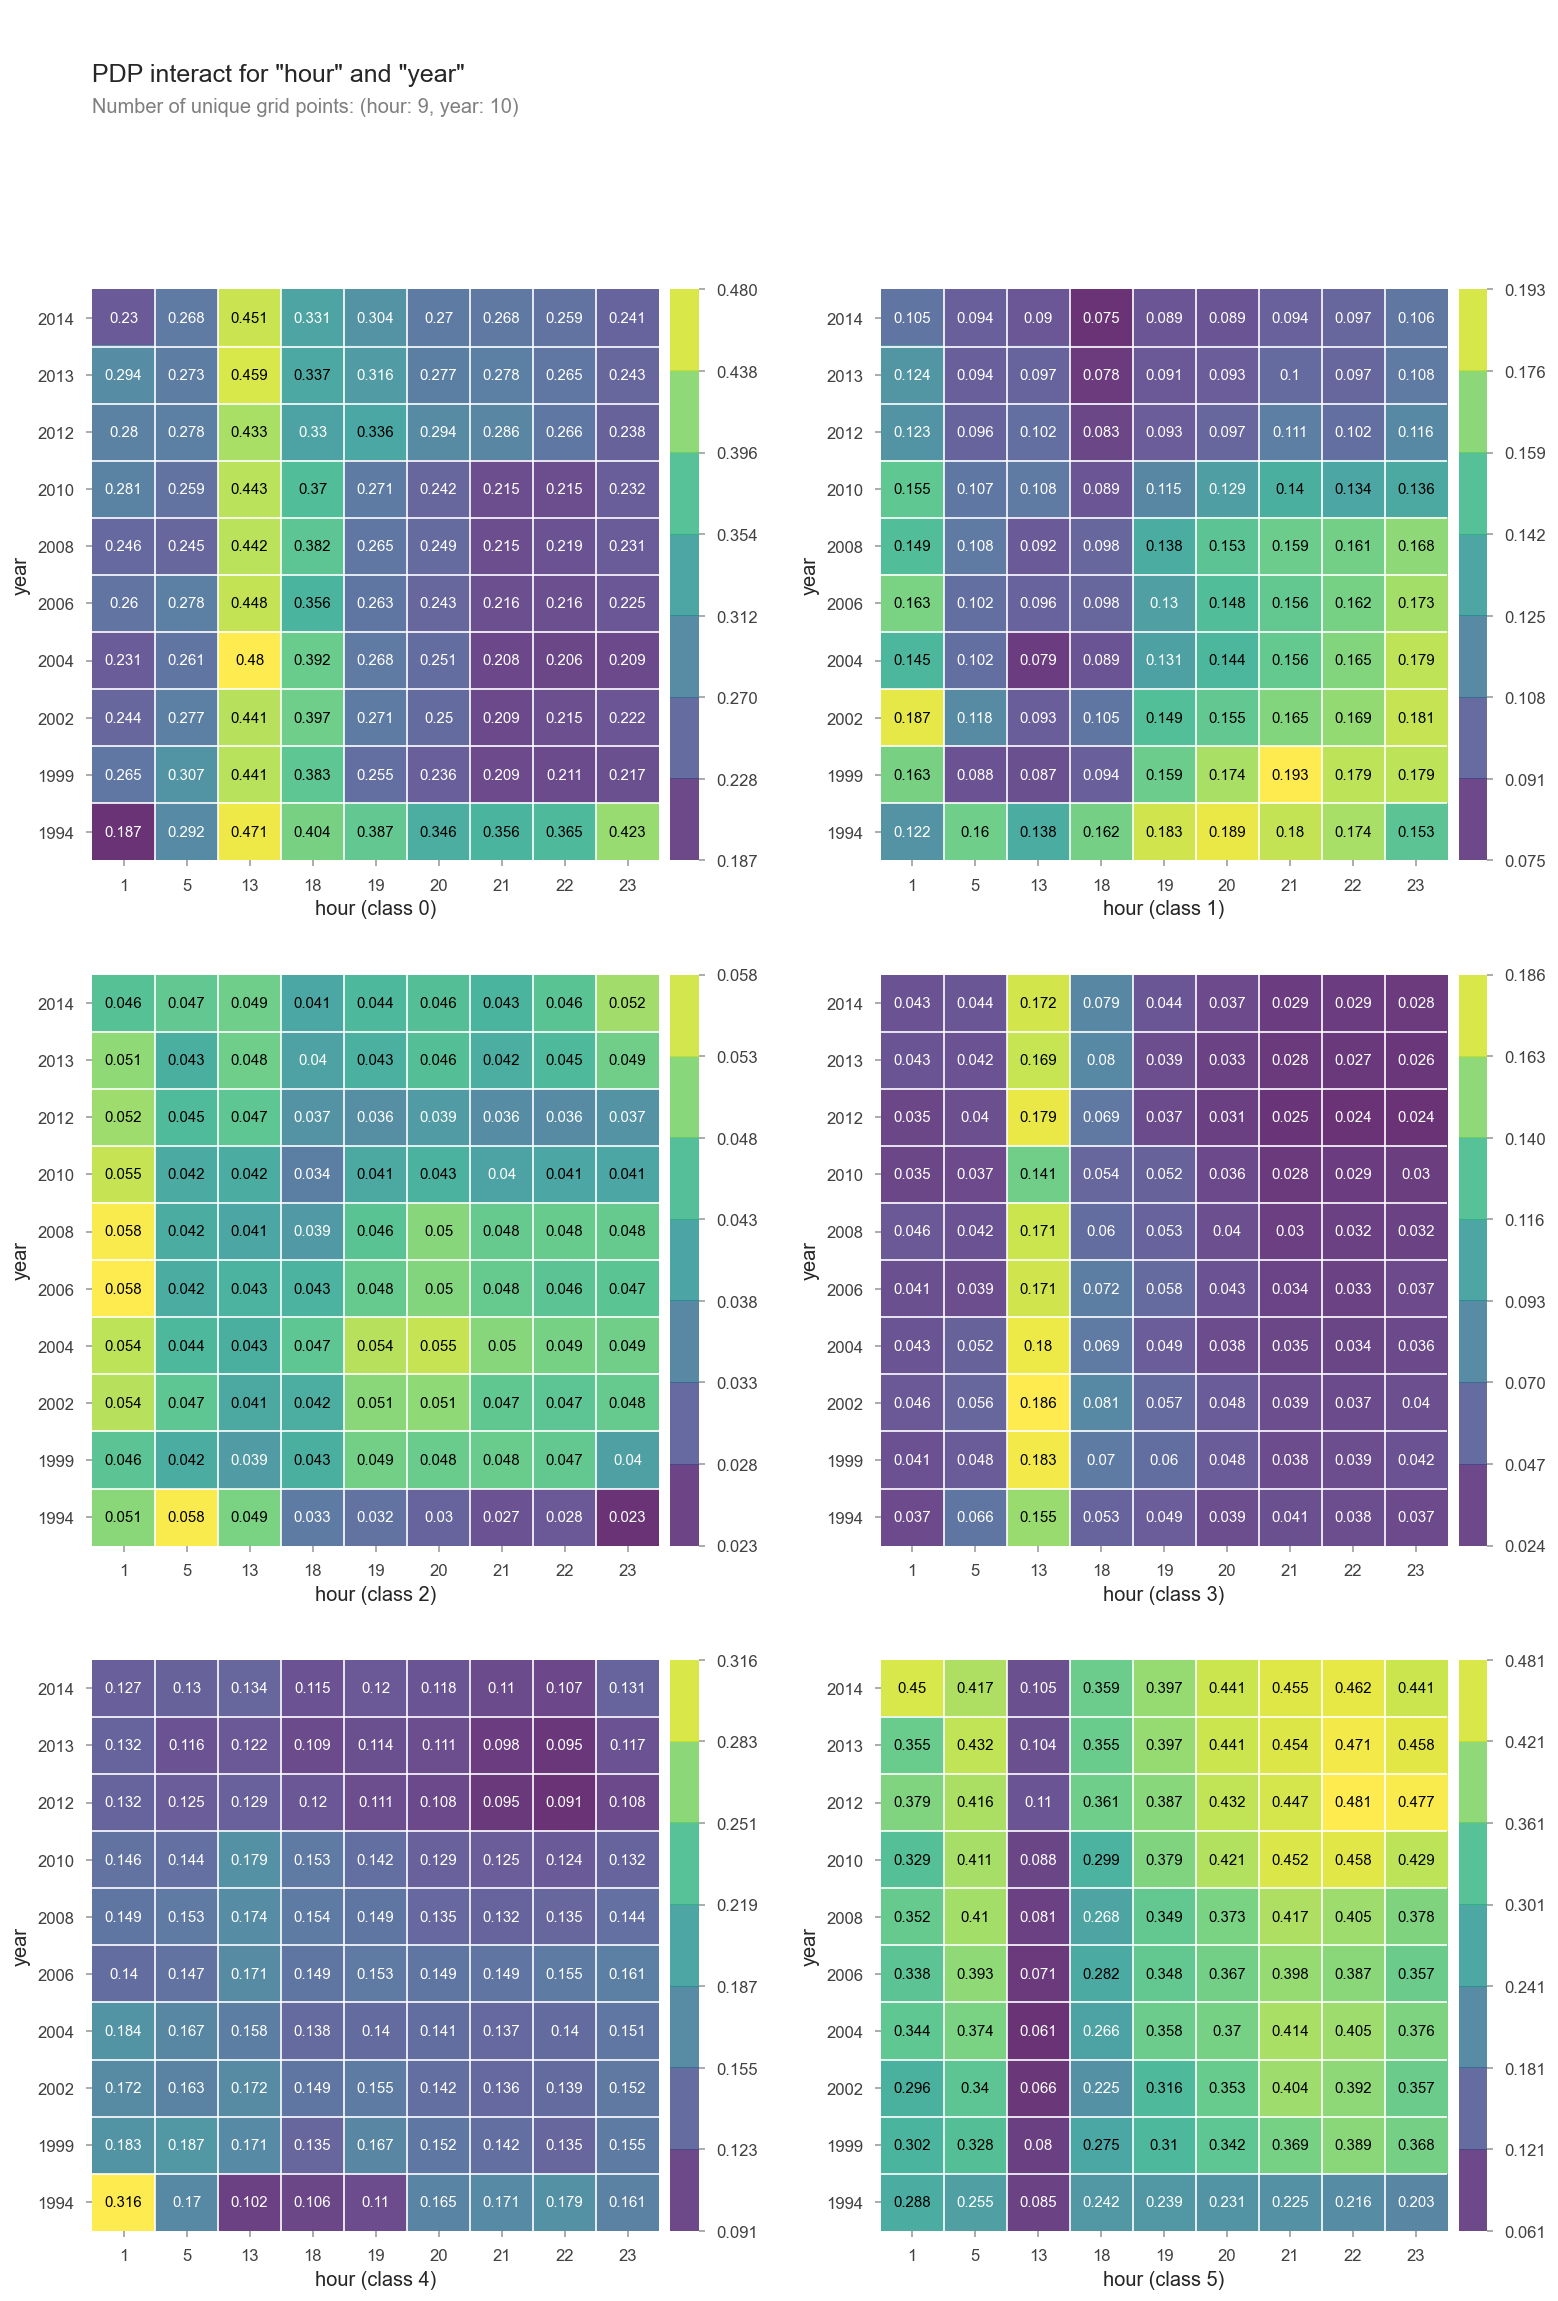

In [86]:
# Define features for the plot:
feats1 = ['hour', 'year']

# Set my perameters for the plot:
inter1 = pdp_interact(model=xg_mod, dataset=vxg_trans, features=feats1, 
                   model_features=X_val.columns)

# Create the plot:
pdp_interact_plot(inter1, plot_type='grid', feature_names=feats1);